# Table of Contents

1. Data Preprocessing

2. Feature Engineering

3. Model Building

4. Model Evaluation 

5. Holdout Dataset Prediction

---

In [105]:
# import libraries
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
# import tensorflow as tf
# from tensorflow import keras
import warnings
warnings.filterwarnings('ignore')
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, precision_recall_curve
from xgboost import XGBClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
import pickle
import tensorflow as tf
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
from keras.layers import Activation
from sklearn.base import TransformerMixin
from autogluon.tabular import TabularDataset, TabularPredictor
from sklearn.ensemble import GradientBoostingClassifier, StackingClassifier
import matplotlib.patches as mpatches
import dalex as dx
from sklearn.ensemble import IsolationForest


In [106]:
from utils import you_never_know_where_it_is as ynk
import importlib
importlib.reload(ynk)
from utils.you_never_know_where_it_is import DataPreprocessor, PerformanceMetrics, create_metrics_dataframe, create_stacking_classifier


# I. Data Preprocessing

In [107]:
df = pd.read_csv('./data/loan_train.csv')

Let's write a class to write all the data preprocessing steps.

Some plot functions

## I.1 Basic Overview Analysis

Eyeball data, check missing values, duplicates

In [108]:
# df.info()


`Check duplicates`

In [109]:
# check duplicates
df.duplicated().sum()

# remove duplicates 
df = df.drop_duplicates()


`Check missing values`

In [110]:
# missing values as a percentage
missing_values = df.isnull().sum()
missing_values = missing_values[missing_values > 0]
missing_values = missing_values / len(df) * 100
missing_values = missing_values.sort_values(ascending=False)

In [111]:
# number of missing cols containing missing values
print('number of cols containing missing values:', len(missing_values))

# number of missing values in the loan_status 
print('number of missing values in the loan_status:', df['loan_status'].isnull().sum())

number of cols containing missing values: 51
number of missing values in the loan_status: 0


Apparently, all cols contain missing values except the label. This is quite annoying

Here is the plan to deal with missing values:
- if the missing values are less than 1% of the total, we can drop the rows 

- if the missing values are less than 10% of the total we can do some further investigation to see if it's appropriate to fill these missing values with median or mode 

- If the missing values are greater than 10%, let's investigation to see if there is a reason for the missing values. If not, we can decide to drop some cols wikth extremely high missing values

In [112]:
# get the index for those have value less than 1% in missing_values
small_missing_values= missing_values[missing_values < 1].index

small_missing_values.tolist()

# drop the rows with missing values in the small_missing_values
df = df.dropna(subset=small_missing_values)

In [113]:
# check the remaining missing values
missing_values = df.isnull().sum()
missing_values = missing_values[missing_values > 0]
missing_values = missing_values / len(df) * 100
missing_values = missing_values.sort_values(ascending=False)
missing_values

next_pymnt_d              92.307172
mths_since_last_record    91.593369
mths_since_last_delinq    63.606225
desc                      31.725304
emp_title                  6.062246
pub_rec_bankruptcies       2.919486
emp_length                 2.547361
dtype: float64

These faetures are a bit complicated, and require careful handling. Thus, we will take care of them in **feature engineering** 

## I.2 Univariate Analysis

In [114]:
# initialize the DataPreprocessor
dp = DataPreprocessor()

### I.2.1 Numerical Features

Visualize histogram of all these numerical features to see the distribution of the data and check for outliers as well as invalid numerical features. Some of them could be potential categorical features instead

In [115]:
# extract numerical features from the dataset 
numerical_features = df.select_dtypes(include=[np.number]).columns.tolist()

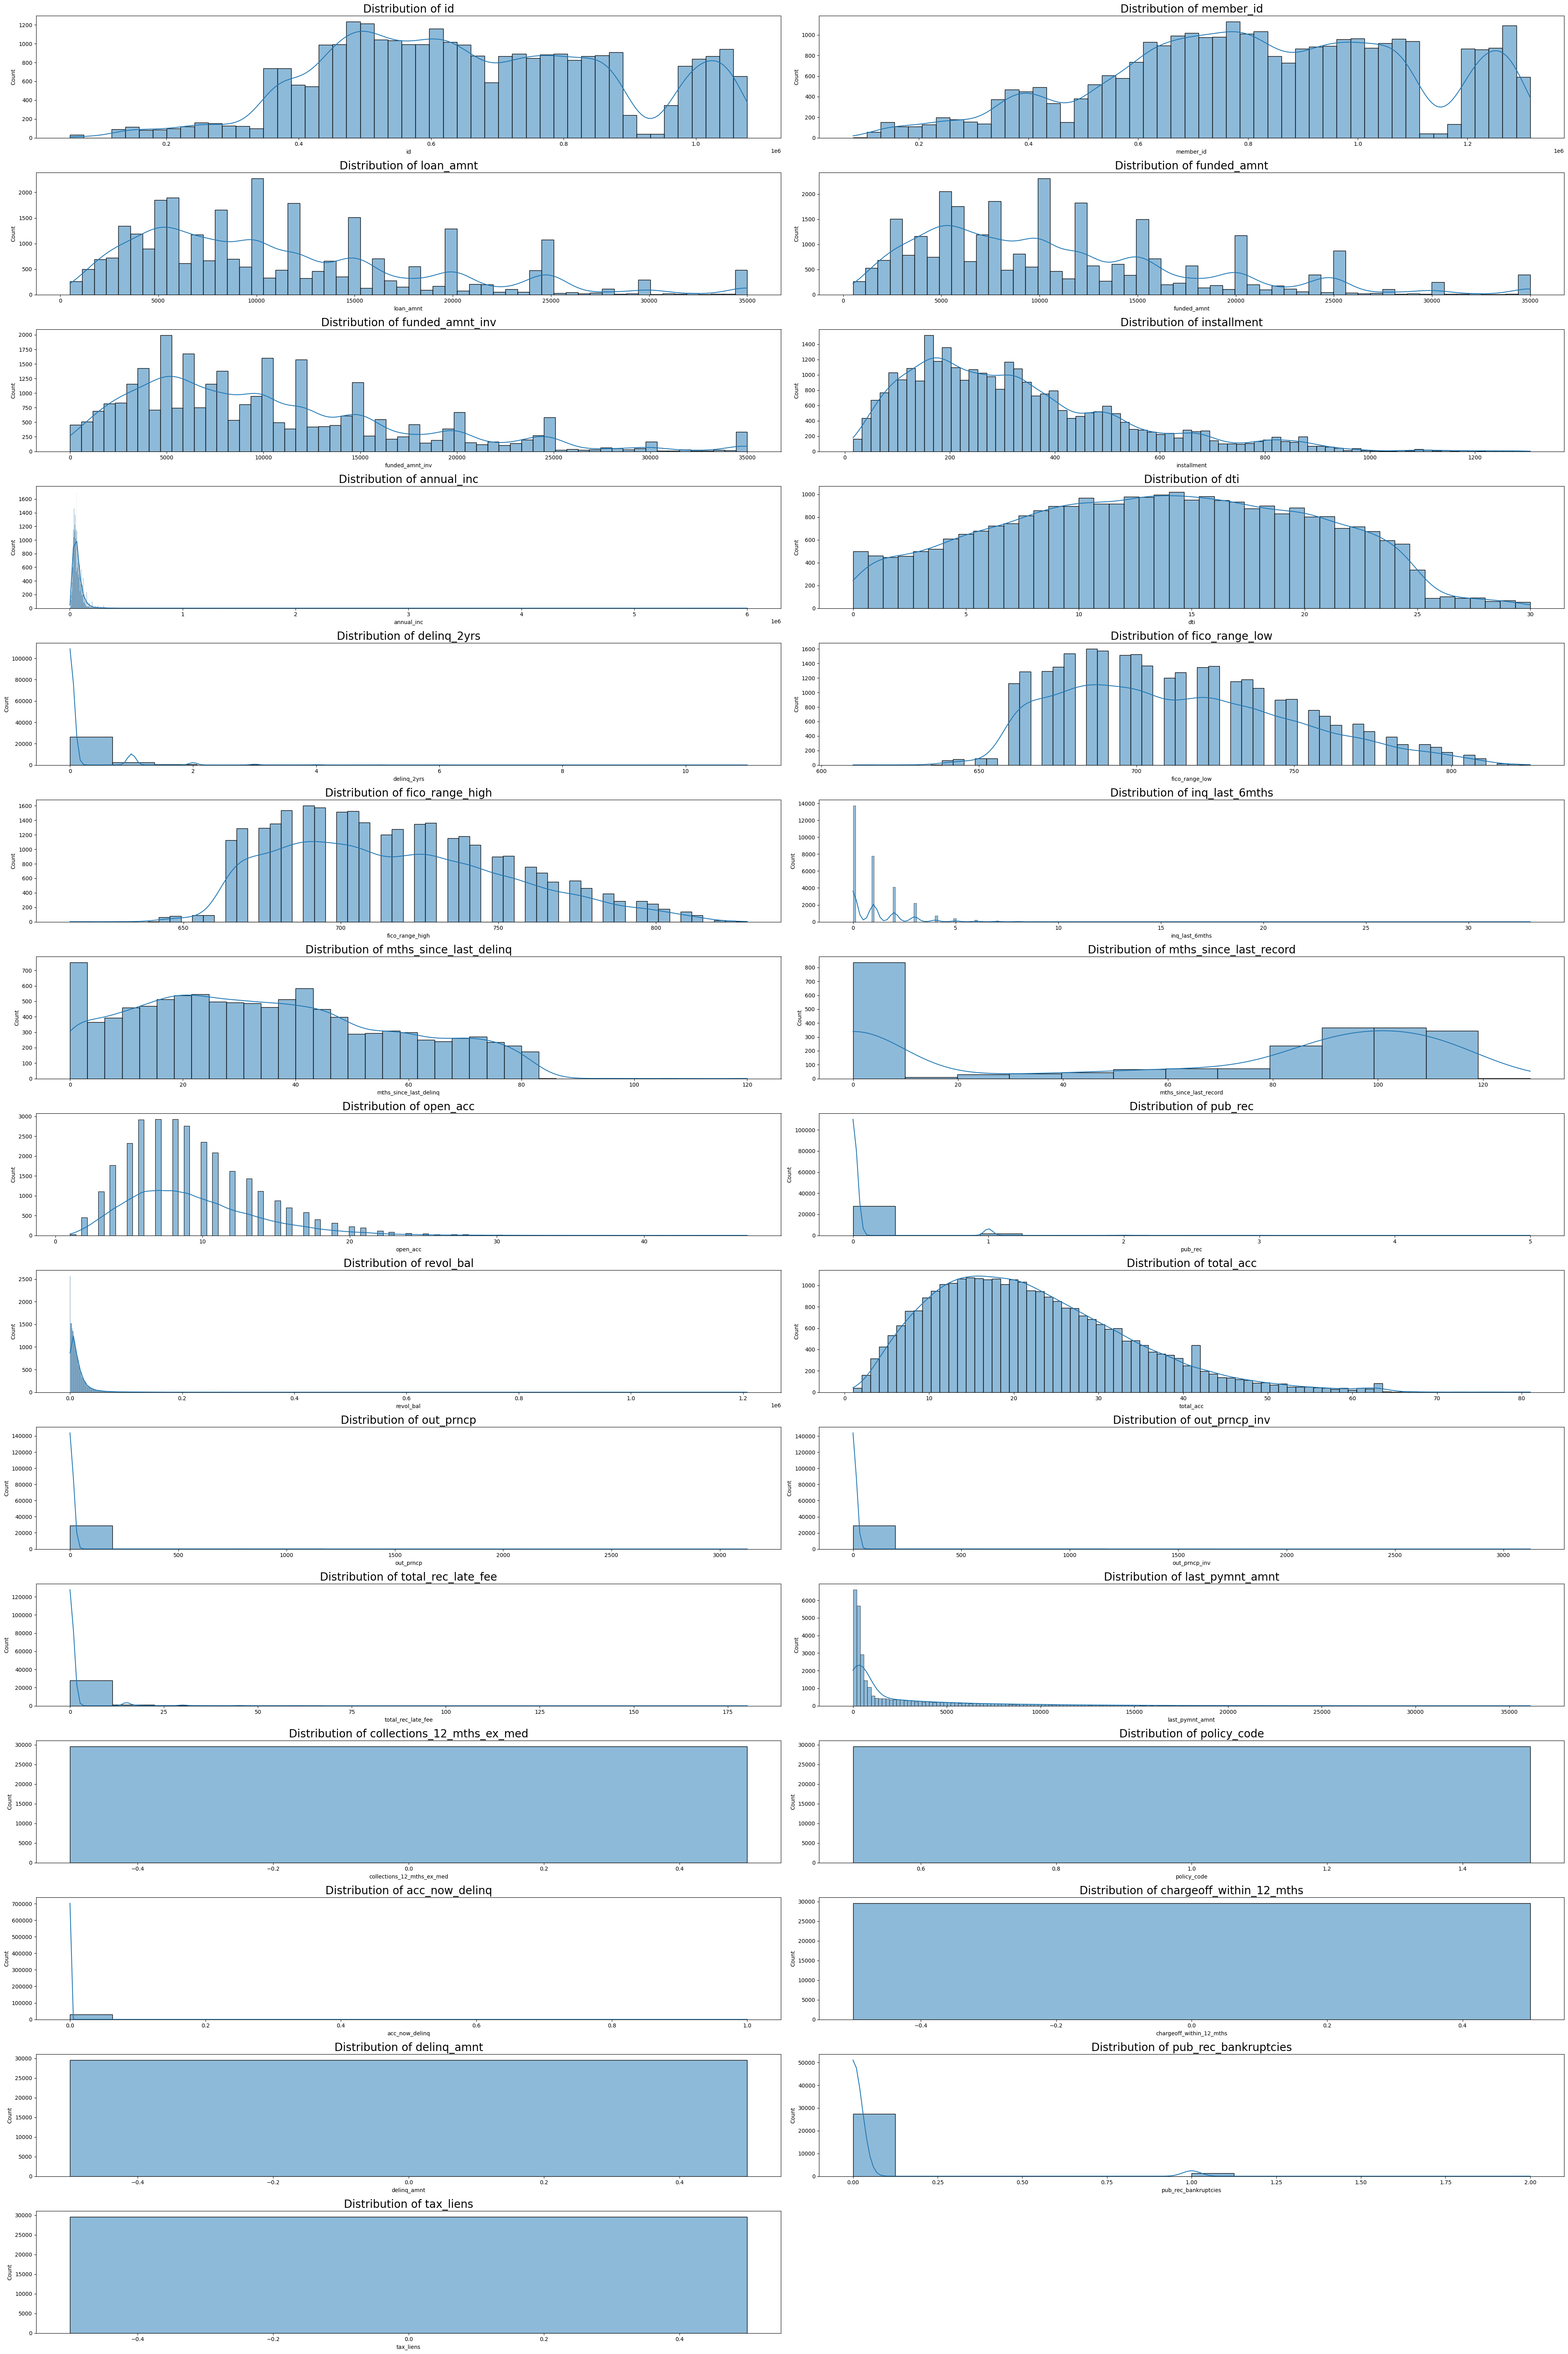

In [116]:
ynk.analyze_numerical(df, numerical_features)

It appears that none of them follows a normal distribution. Some distribution is quite suspicious and we need to investigate further.

Some of these variables have just ONE value in the entire column. we can consider removing these columns as they don't provide any information.

- Here is the list of useless numerical cols that don't provide any good information:

In [117]:
useless_cols = ['chargeoff_within_12_mths', 'collections_12_mths_ex_med', 'delinq_amnt', 'tax_liens', 'policy_code', 'acc_now_delinq', 'total_rec_late_fee']

Let's just drop them to make our life easier

In [118]:
df = dp.drop_useless_numerical_cols(df)

Some cols are actually numerical but they are in the categorical form. We need to convert them to numerical form

In [119]:
# df = dp.convert_interest_rate_to_numerical(df)

There are still some issues that we need to address, but we can take care of them later in the feature engineering section. Let's just now move on to the categorical section


### 1.2.2 Categorical Features

In [120]:
# extract categorical features from the dataset
categorical_features = df.select_dtypes(include=[object]).columns.tolist()

# check the number of levels in these features 
for col in categorical_features:
    print(f"{col}: {df[col].nunique()}")

term: 2
int_rate: 389
grade: 7
sub_grade: 35
emp_title: 21998
emp_length: 11
home_ownership: 5
verification_status: 3
issue_d: 53
loan_status: 2
desc: 20151
purpose: 14
addr_state: 50
earliest_cr_line: 516
revol_util: 1093
next_pymnt_d: 95
last_credit_pull_d: 106


`Low Cardinality` (Less than 10 unique values)

In [121]:
low_card =  ['term', 'grade', 'home_ownership', 'verification_status', 'loan_status']

term
36 months    74.3%
60 months    25.7%
Name: proportion, dtype: object


grade
B    29.03%
A    24.07%
C    20.35%
D    14.29%
E     7.99%
F     3.02%
G     1.24%
Name: proportion, dtype: object


home_ownership
RENT        47.15%
MORTGAGE     44.9%
OWN          7.64%
OTHER         0.3%
NONE         0.01%
Name: proportion, dtype: object


verification_status
Not Verified       43.87%
Verified            31.9%
Source Verified    24.23%
Name: proportion, dtype: object


loan_status
current    85.18%
default    14.82%
Name: proportion, dtype: object




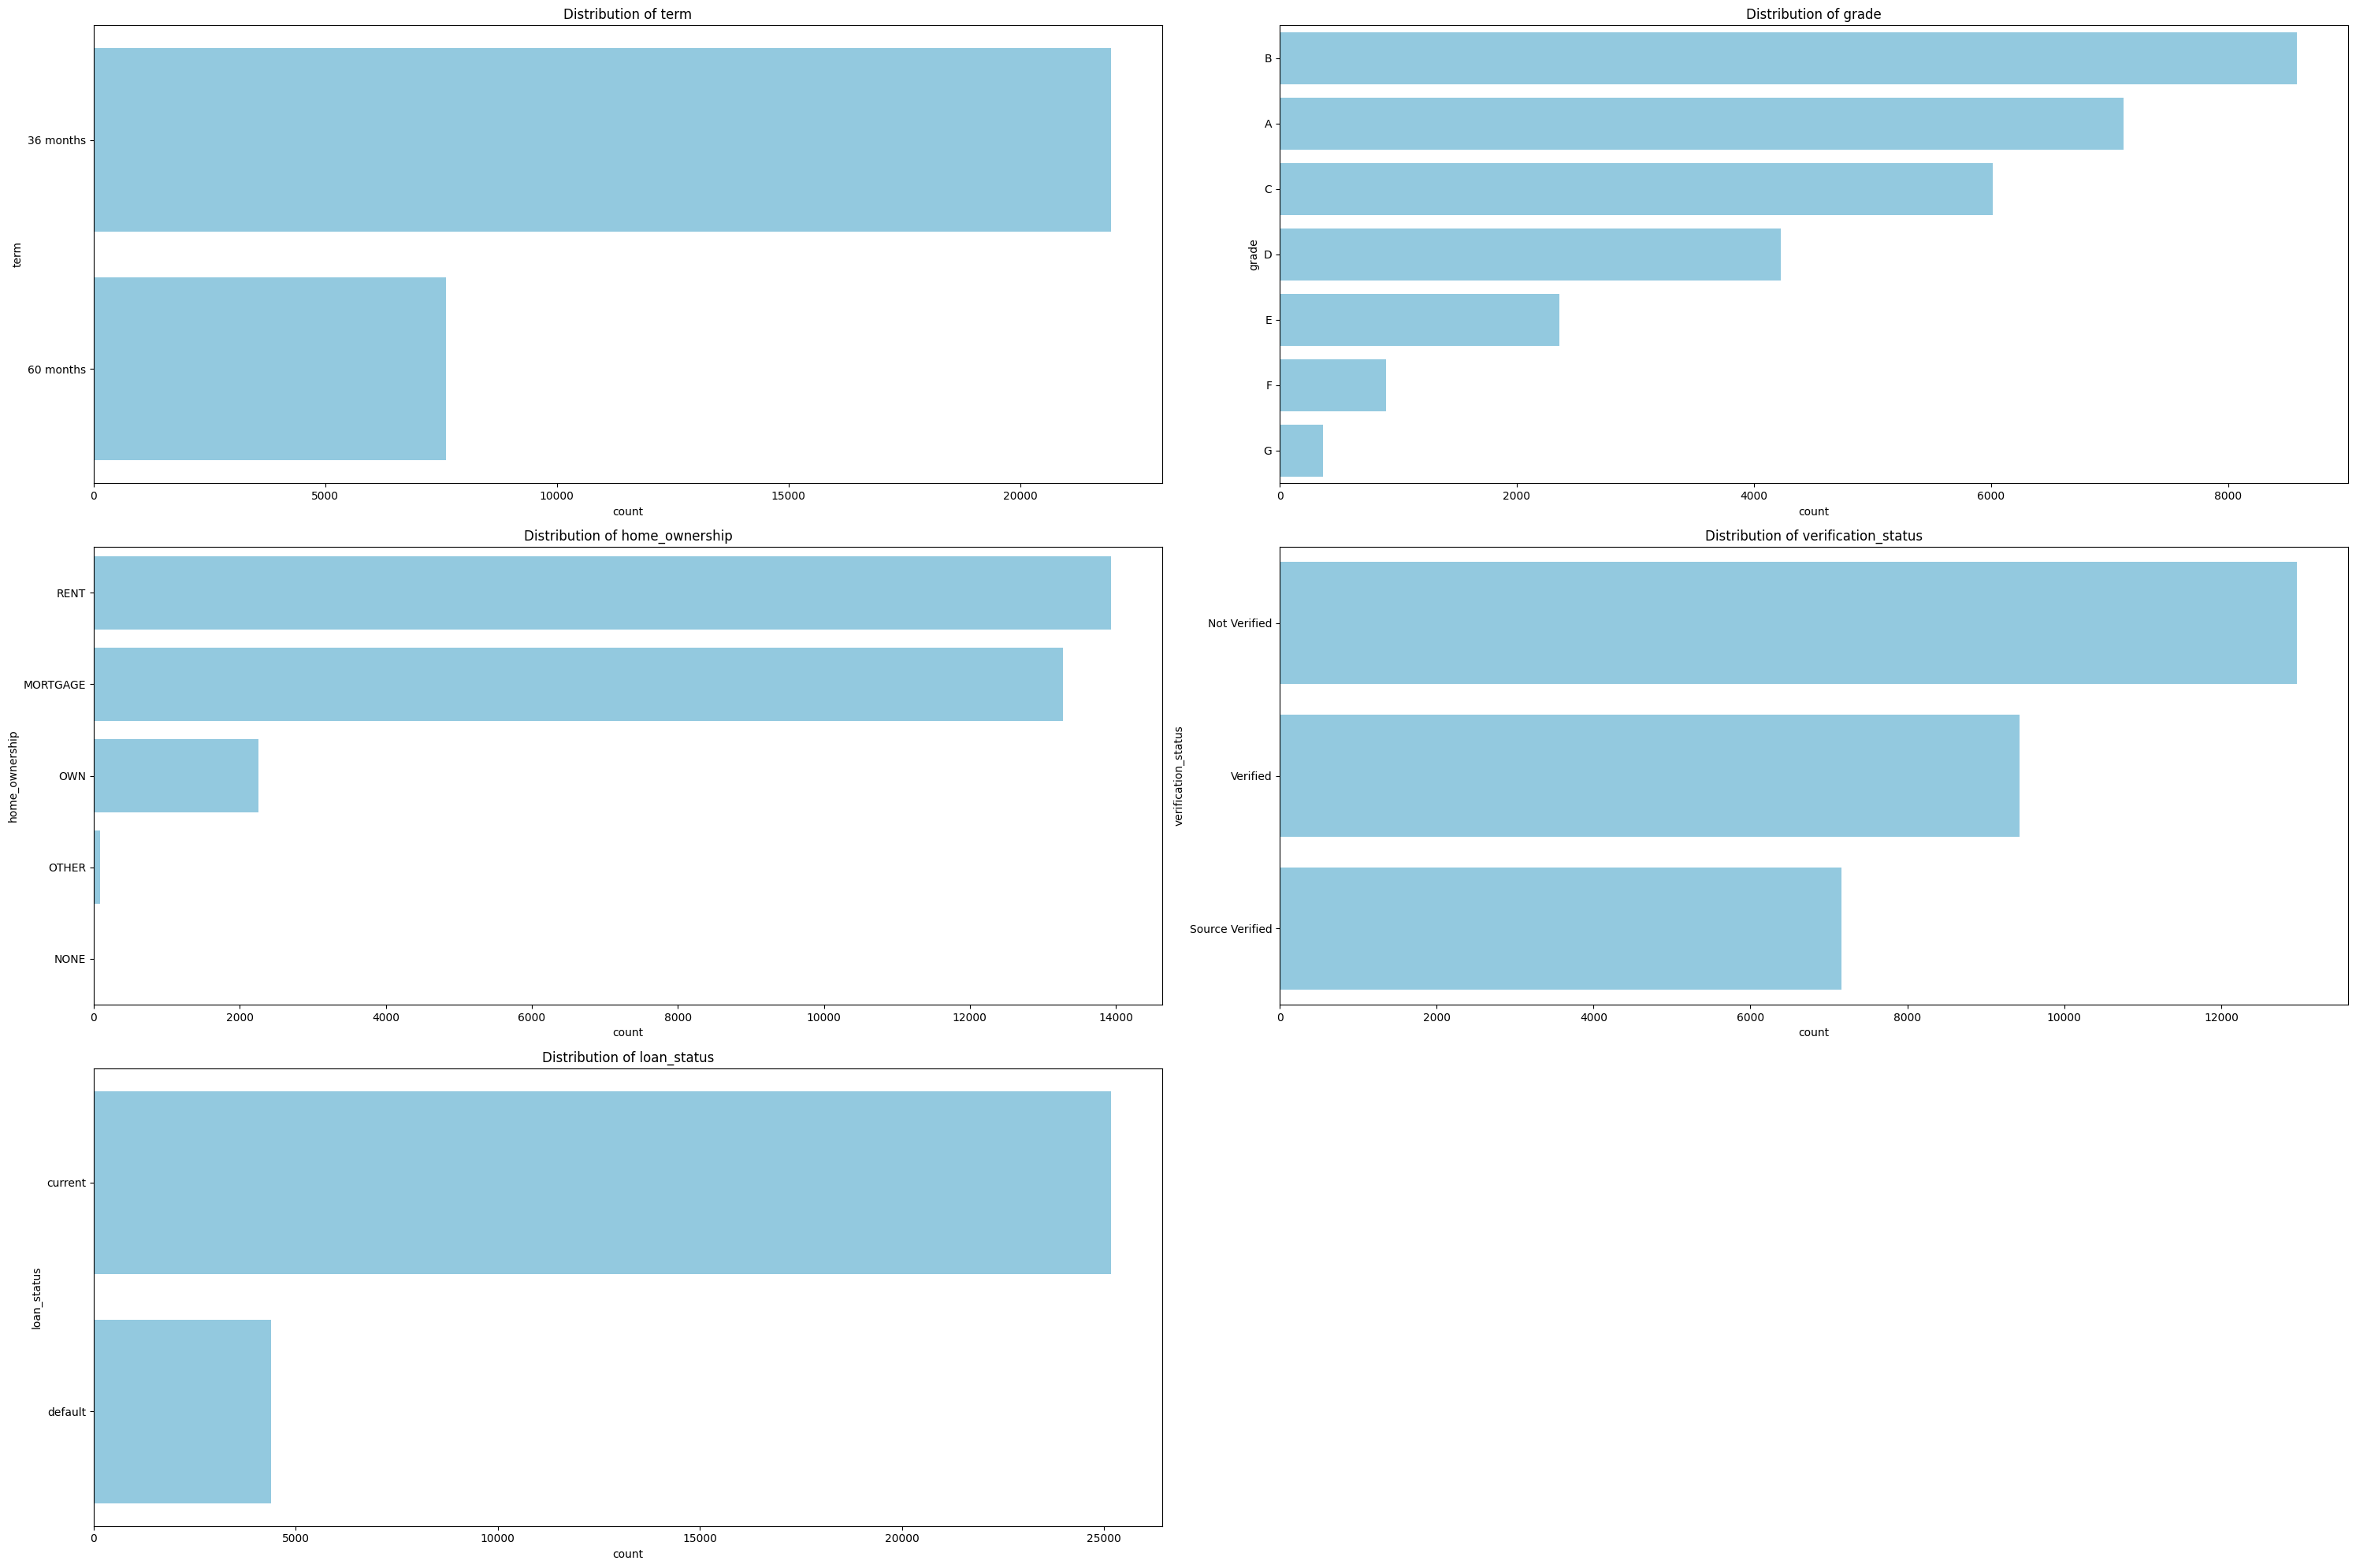

In [122]:
ynk.visualize_categorical(df, low_card, figsize=(30, 20))

Potential transformation needed: home_ownership

`Med Cardinality`

In [123]:
med_card = ['sub_grade', 'emp_length', 'purpose', 'addr_state']

sub_grade
B3    7.05%
A4     6.9%
A5     6.6%
B5     6.5%
B4    5.95%
C1    5.38%
B2    5.01%
C2    4.89%
B1    4.52%
A3     4.2%
C3    3.95%
A2    3.72%
D2    3.61%
C4    3.15%
D3    3.09%
C5    2.98%
D4     2.7%
A1    2.66%
D1     2.5%
D5    2.41%
E1    2.05%
E2    1.86%
E3    1.59%
E4    1.31%
E5    1.18%
F1    0.92%
F2     0.7%
F3    0.59%
F4    0.48%
F5    0.34%
G1    0.34%
G4    0.25%
G2    0.24%
G5    0.21%
G3     0.2%
Name: proportion, dtype: object


emp_length
10+ years    22.77%
< 1 year     11.92%
2 years      11.42%
3 years      10.39%
4 years       8.83%
1 year         8.7%
5 years       8.43%
6 years       5.81%
7 years        4.5%
8 years       3.88%
9 years       3.35%
Name: proportion, dtype: object


purpose
debt_consolidation    46.53%
credit_card           12.93%
other                 10.36%
home_improvement       7.48%
major_purchase         5.52%
small_business         4.66%
car                    3.77%
wedding                2.36%
medical                1.78%
mo

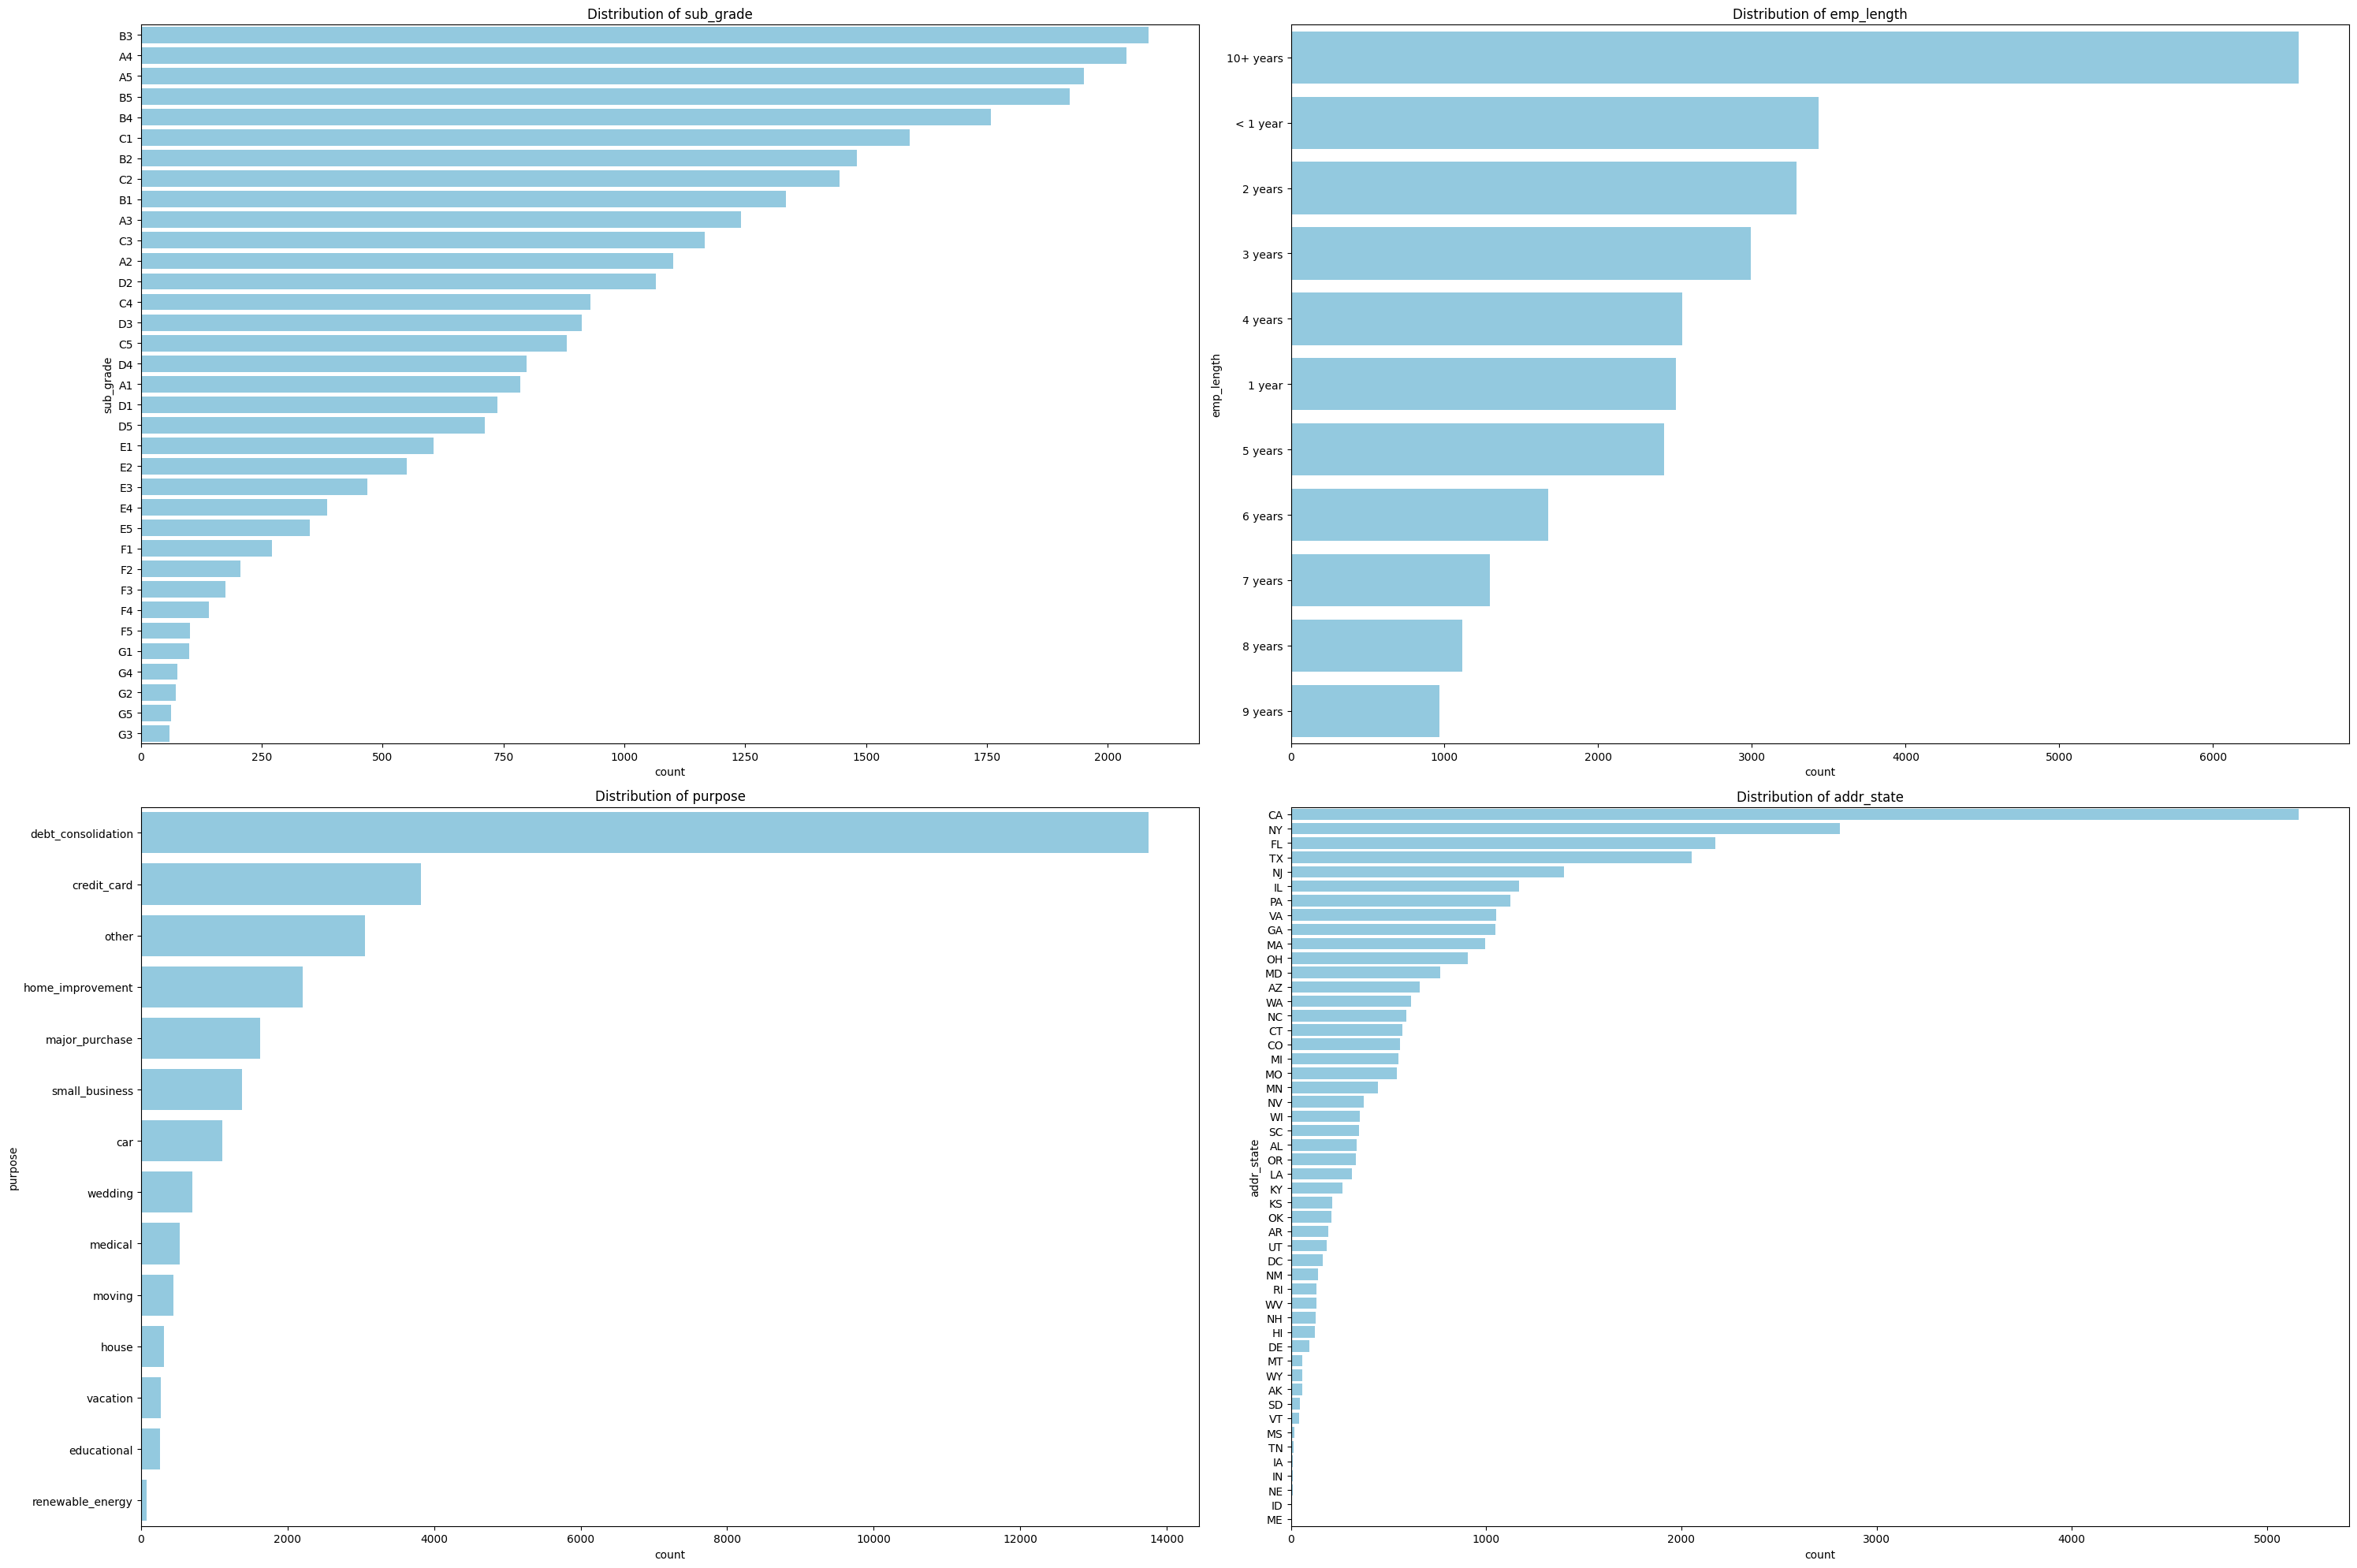

In [124]:
ynk.visualize_categorical(df, med_card, figsize=(30, 20))

`Large Cardinality `

In [125]:
large_card = ['issue_d', 'desc', 'earliest_cr_line', 'next_pymnt_d', 'last_credit_pull_d', 'emp_title']

In [126]:
# unique values in these features
for col in large_card:
    print(f"{col}: {df[col].nunique()}")

issue_d: 53
desc: 20151
earliest_cr_line: 516
next_pymnt_d: 95
last_credit_pull_d: 106
emp_title: 21998


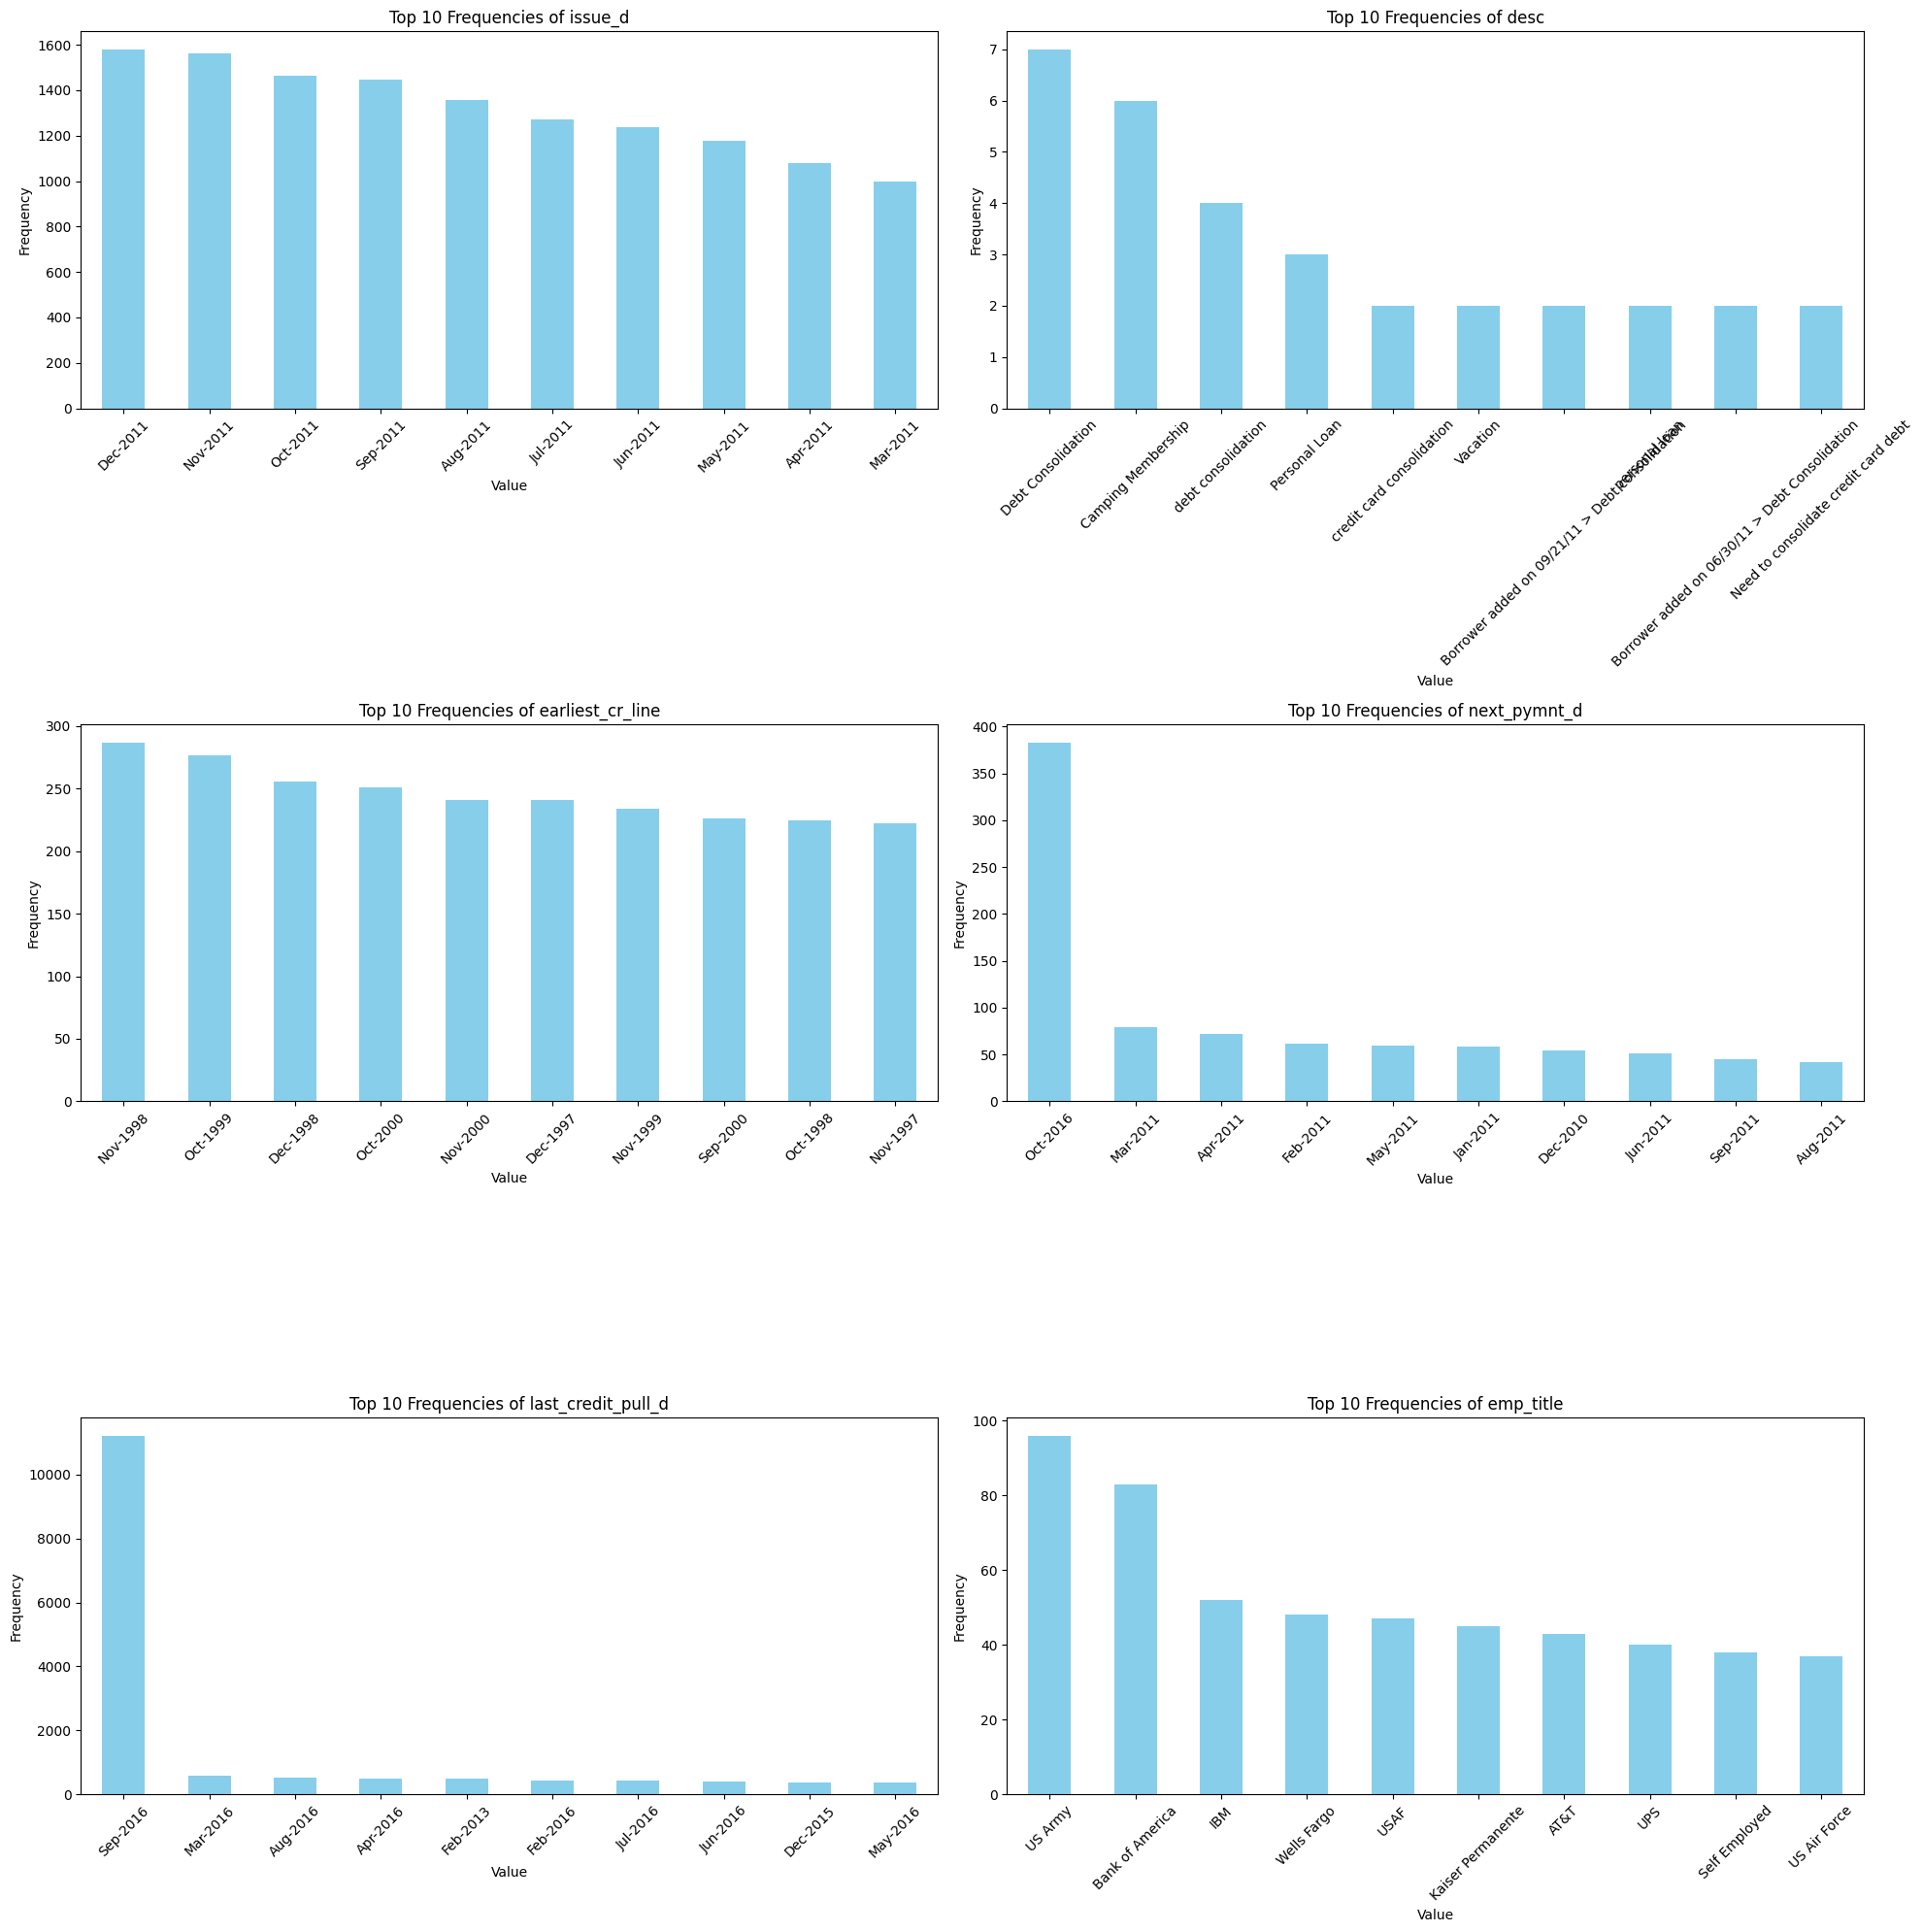

In [127]:
ynk.plot_top_10_frequencies(df, large_card)

The majority of title is debt consolidation and debt consolidation loan. On the other hand, Oct 2016 is the most frequent next_pymnt_d. Also, an overwhelming majority of last_credit_pull_d is Sep 2016

## I.3 Bivariate Analysis

Explore the relationship between the target variable (loan_status) and other features

In [128]:
# update numerical feature list 
numerical_features = df.select_dtypes(include=[np.number]).columns.tolist()

The distribution between target variabel and other numerical features is quite similar. However, we can still spot a few difference. For example, the median interest rate for default loan is slightly higher than that of current loan. Meanwhile, fico_range_high is lower for default loan than that of current loan 

`Numerical Features and Target Variable`

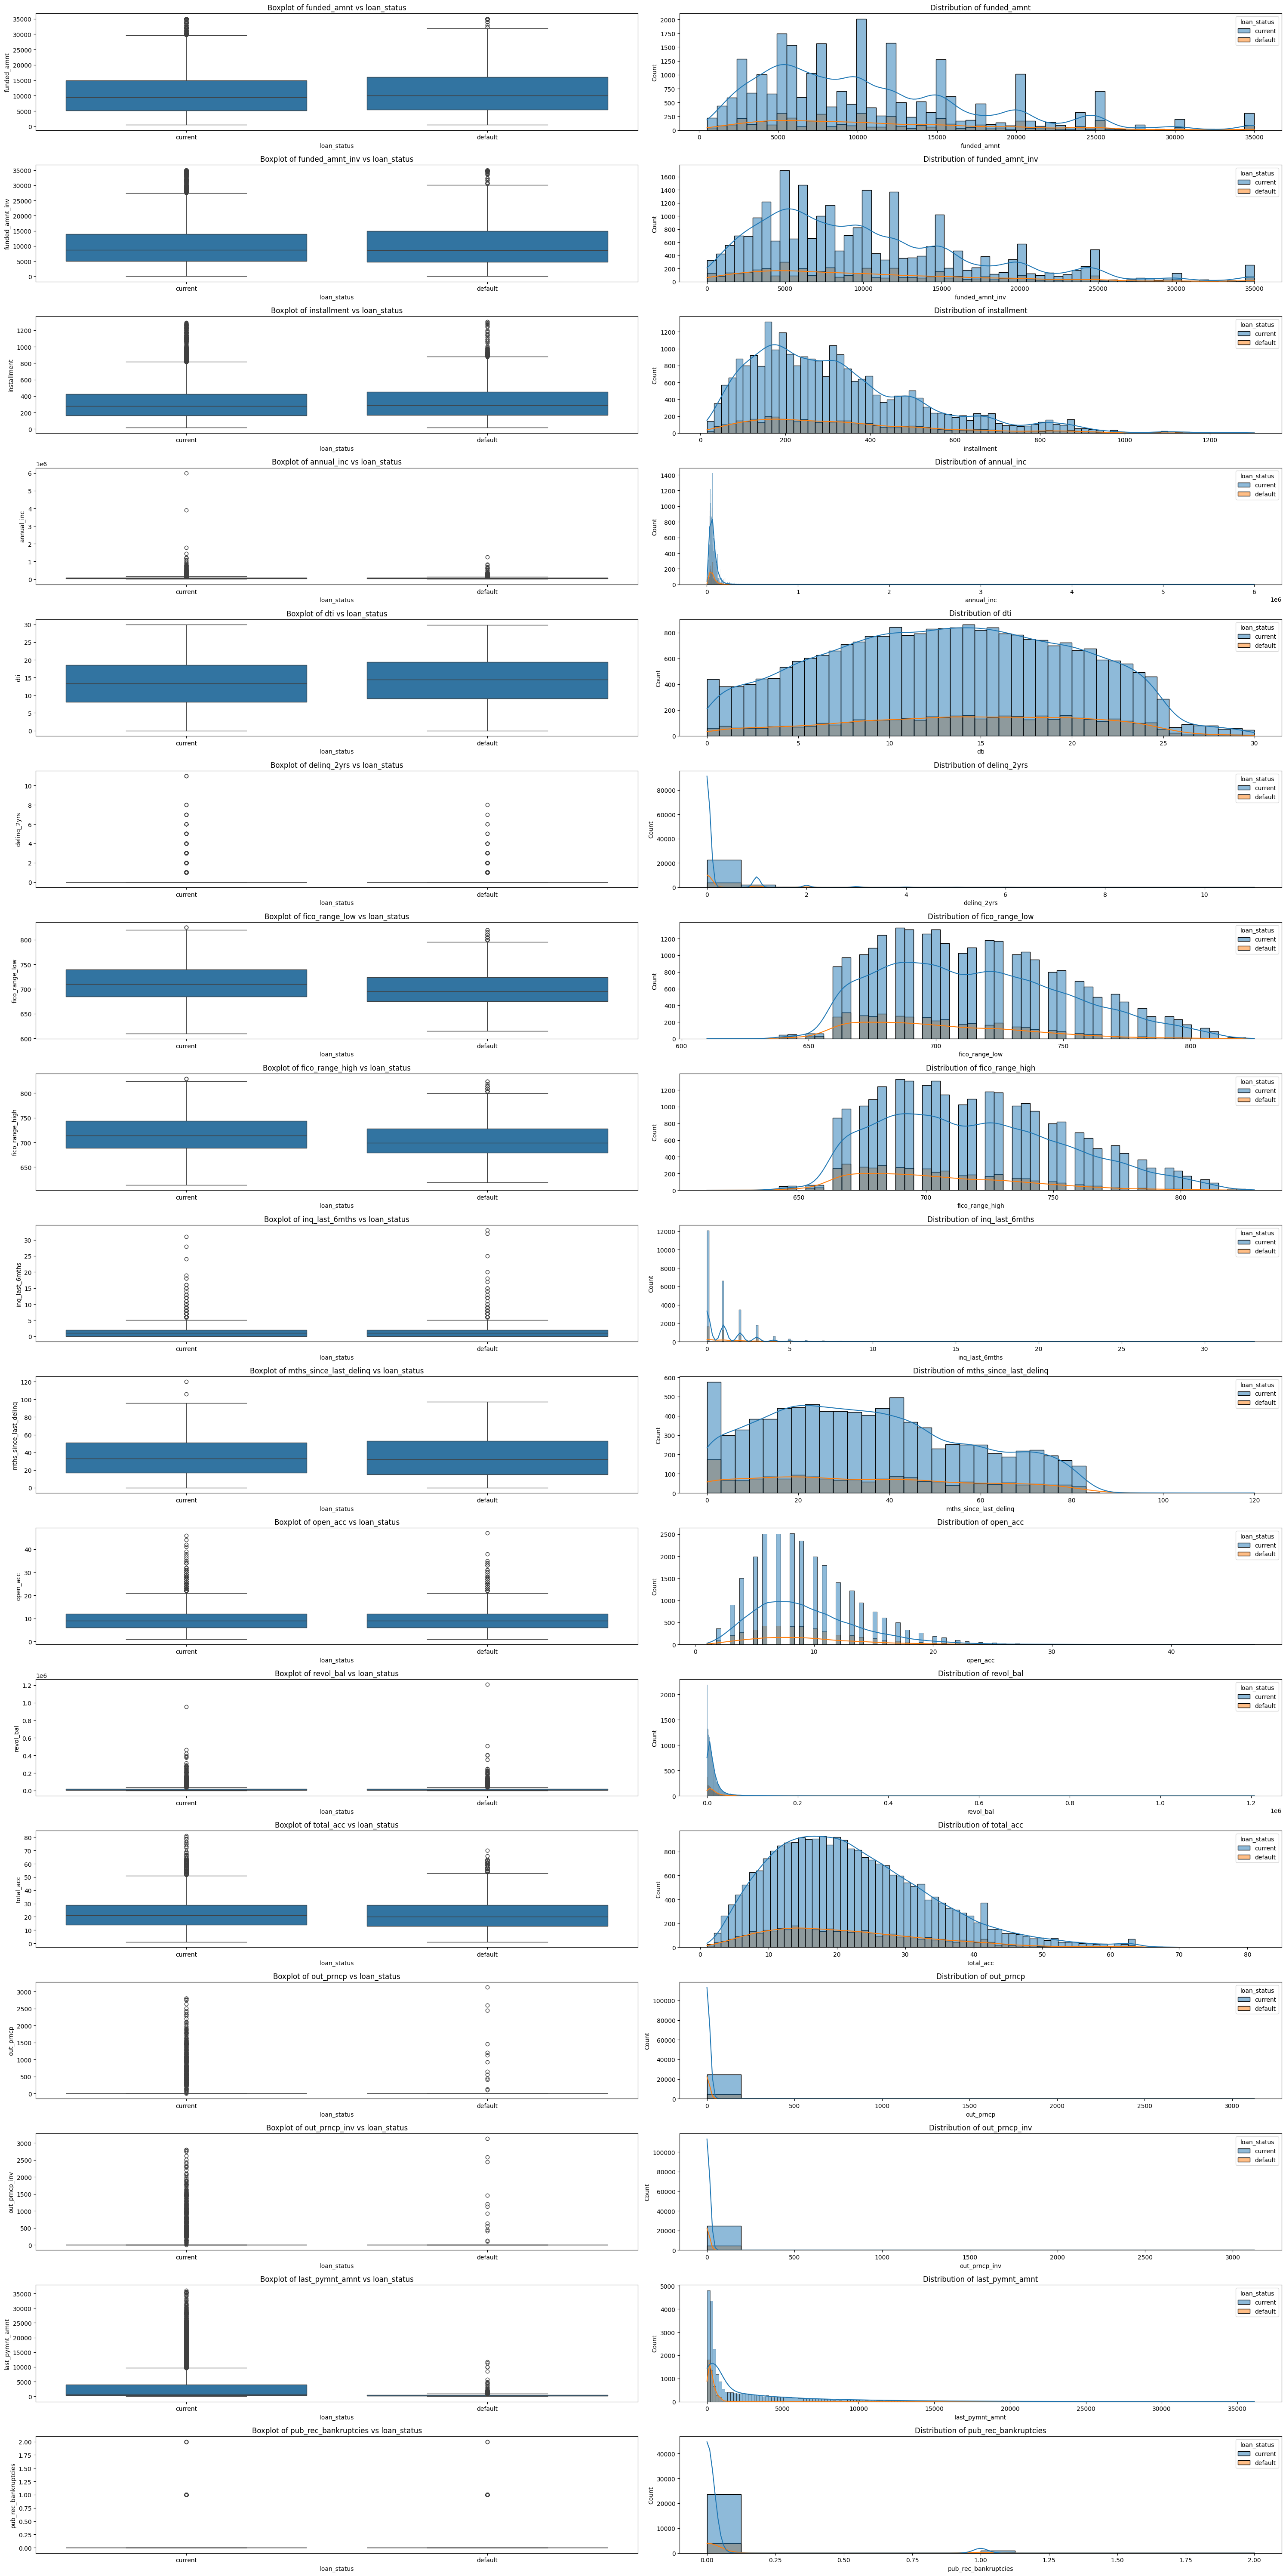

In [129]:
ynk.plot_boxplot_and_histogram(df, numerical_features, 'loan_status')

`Categorical Features and Target Variable`

Low Cardinality

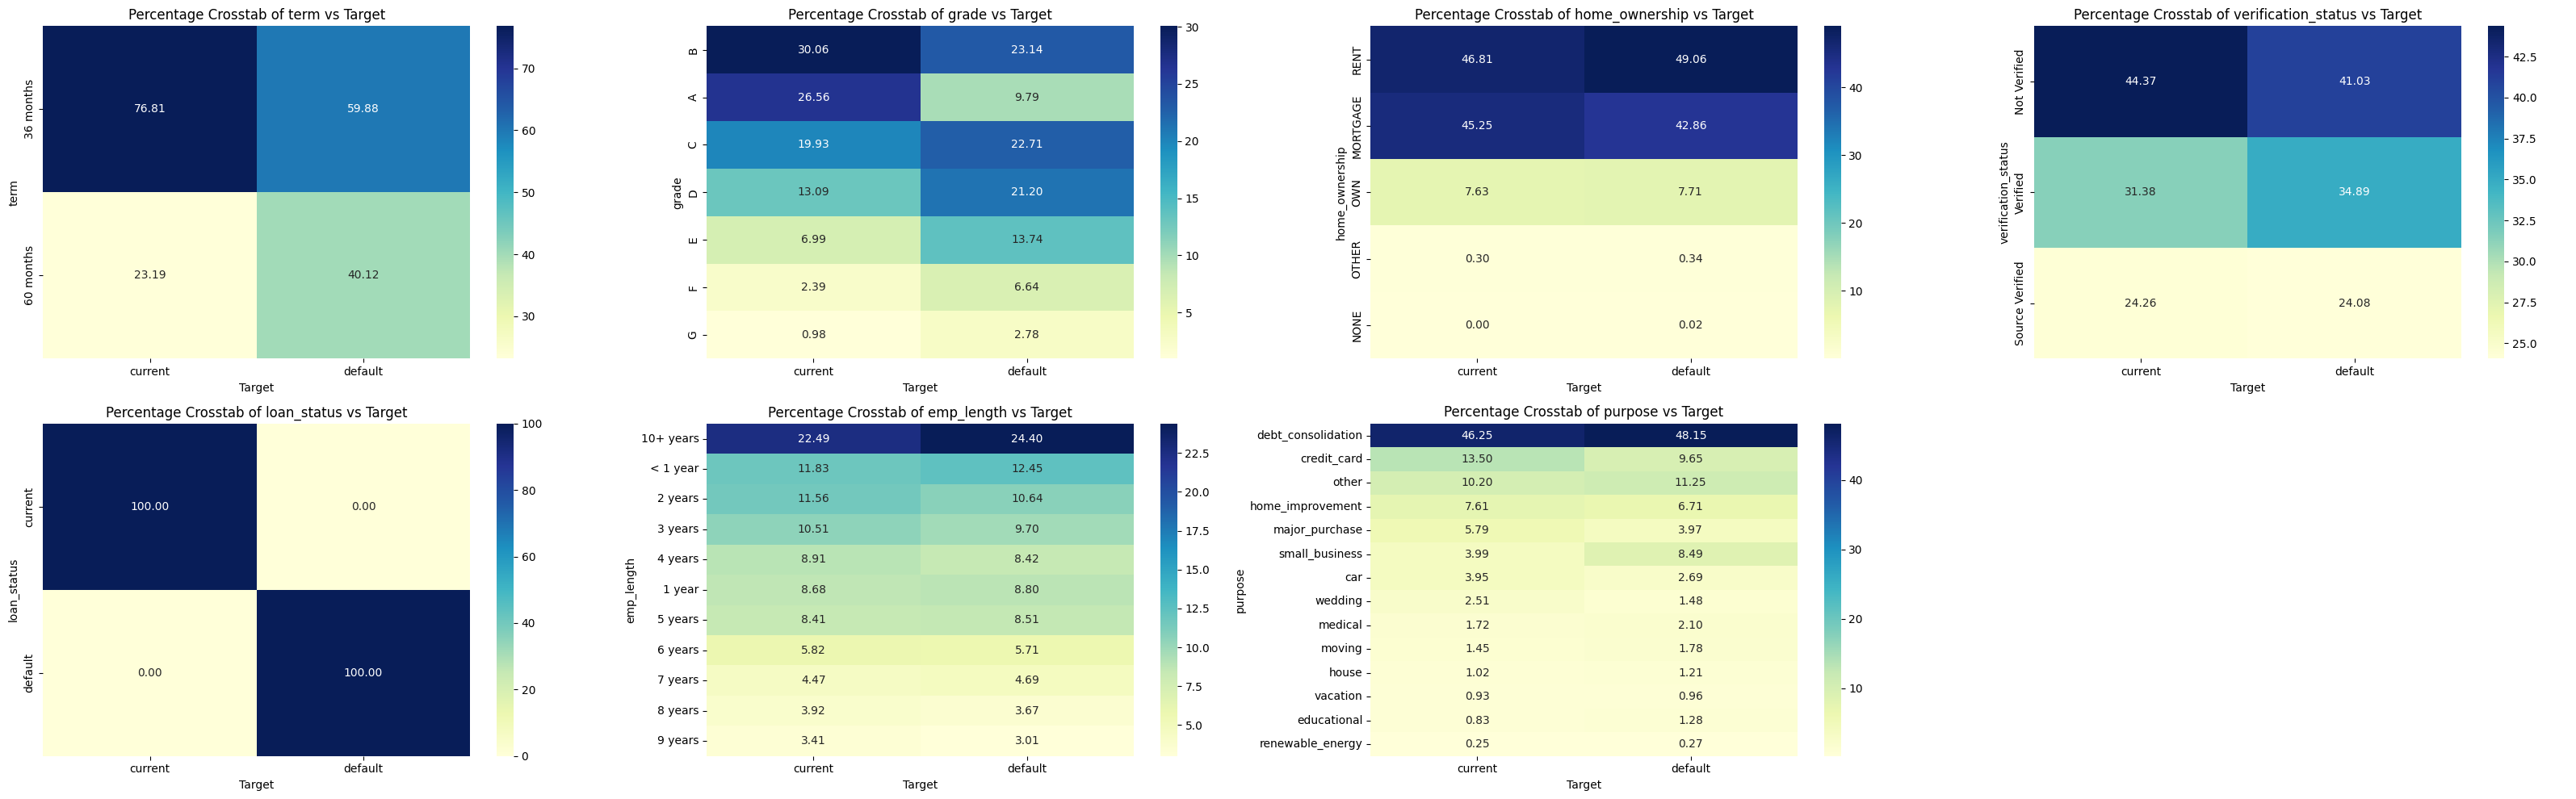

In [130]:
ynk.plot_percentage_crosstab(df, df['loan_status'], low_card + ['emp_length','purpose'])

## I.4 Multivariate Analysis

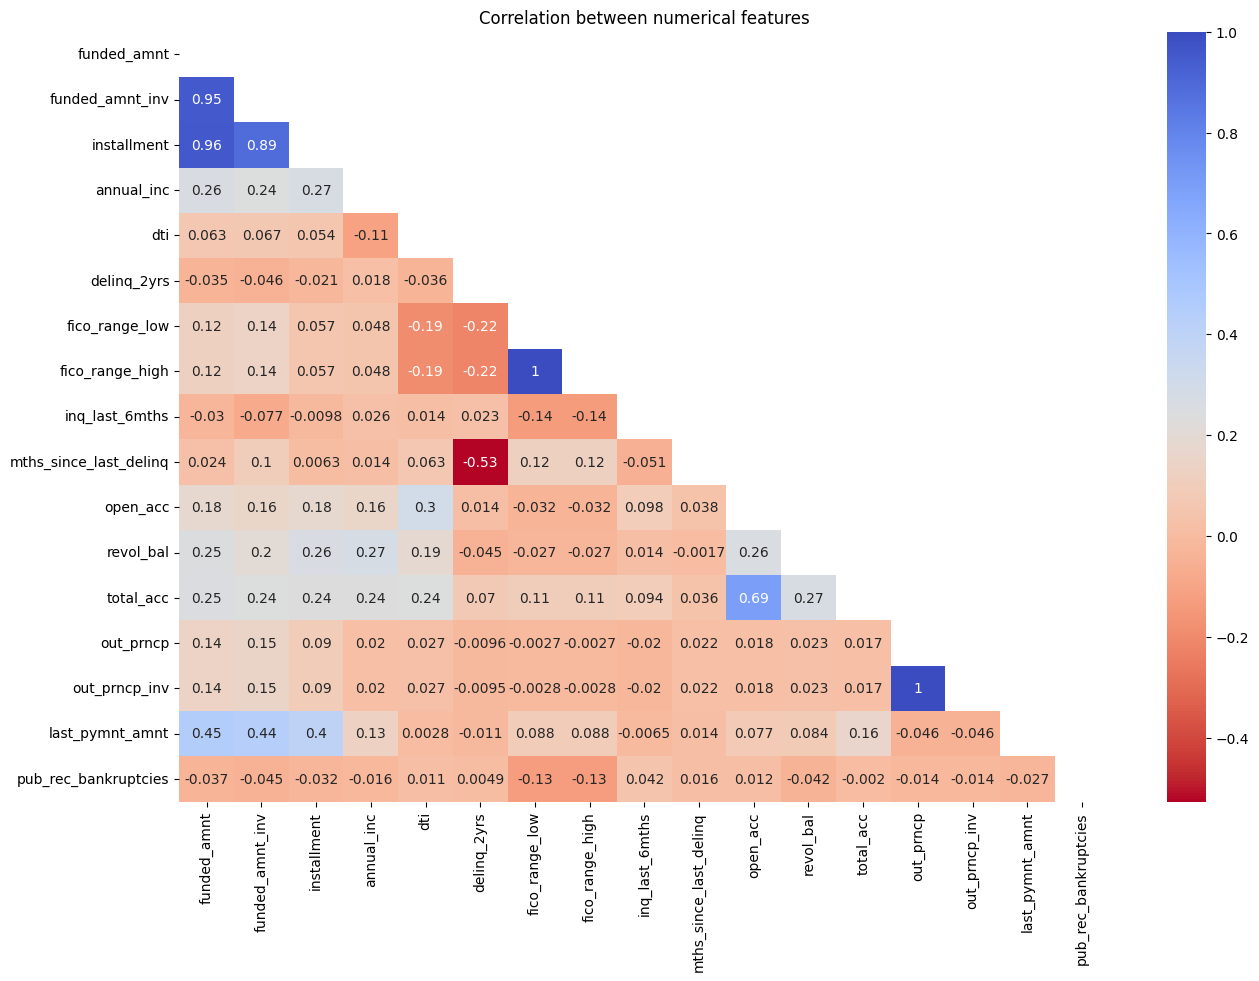

In [131]:
# check the correlation between numerical features
correlation = df[numerical_features].corr()

plt.figure(figsize=(15, 10))
mask = np.zeros_like(correlation, dtype=bool)
mask[np.triu_indices_from(mask)] = True  # Mask the upper triangle
sns.heatmap(correlation, annot=True, cmap='coolwarm_r', mask=mask)
plt.title('Correlation between numerical features')
plt.show()

Some numerical features are highly correlated with one another. We can consider removing some of them to avoid multicollinearity

# II. Feature Engineering

In [132]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('loan_status', axis=1), df['loan_status'], test_size=0.2, random_state=42)

In [133]:
# get the data ready for model building
X_train = dp.feature_engineering_pipeline(X_train)

X_test = dp.feature_engineering_pipeline(X_test)

y_train = dp.convert_target_to_numerical(y_train)

y_test = dp.convert_target_to_numerical(y_test)


# III. Model Building 

In [134]:
# update numerical and categorical features list 
numerical_features = X_train.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X_train.select_dtypes(include=[object]).columns.tolist()


In [135]:
# Create a pipeline to preprocess the data 
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# combine
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)


Before we buid models, let's conduct some anomaly detection to see if there is any abnormal present in our dataset

In [136]:
X_train_anomaly = X_train.copy()

X = preprocessor.fit_transform(X_train_anomaly)

# Initialize the Isolation Forest model
iso_forest = IsolationForest(n_estimators=100,
                             contamination=0.01, # use 'auto'
                             random_state=42)

# Fit the model
iso_forest.fit(X)

# Predict anomalies (-1 for anomalies, 1 for normal)
anomalies = iso_forest.predict(X)

# Add the anomalies to the original data (optional)
X_train_anomaly['anomaly'] = anomalies

# predict anomalies in the training set 

# Filter the anomalies
anomalies_data = X_train_anomaly[X_train_anomaly['anomaly'] == -1]

# Analyze the anomalies
print(f"Number of anomalies detected {anomalies_data.shape[0]} ", )

anomalies_data.head().T


Number of anomalies detected 237 


7764            4130              23226  \
funded_amnt                    35000.0         28000.0           20800.0   
funded_amnt_inv                34975.0         28000.0           20775.0   
term                                 0               1                 0   
int_rate                          7.49           12.42             11.48   
installment                    1088.56          628.81            685.75   
grade                                0               1                 1   
sub_grade                           A4              B4                B2   
emp_title                            0               1                 1   
emp_length                         2.0             4.0              10.0   
home_ownership                       1               0                 2   
annual_inc                    162500.0        130000.0          140000.0   
verification_status                  1               2                 0   
issue_d                      62.966667            59.9              82.2   
desc                                 1               0                 1   
purpose                 small_business  major_purchase  home_improvement   
addr_state                          CT              PA                CA   
dti                              27.92            6.66             21.77   
delinq_2yrs                        0.0             0.0               0.0   
earliest_cr_line            333.733333      370.333333        140.033333   
fico_range_low                   770.0           770.0             790.0   
fico_range_high                  774.0           774.0             794.0   
inq_last_6mths                     0.0             4.0               1.0   
mths_since_last_delinq               0               0                 0   
open_acc                          16.0            11.0               6.0   
revol_bal                       2367.0         14506.0             682.0   
revol_util                         7.7            16.8               3.3   
total_acc                         30.0            37.0              15.0   
out_prncp                          0.0             0.0               0.0   
out_prncp_inv                      0.0             0.0               0.0   
last_pymnt_amnt                12646.0        21555.69          20999.81   
next_pymnt_d                         0               0                 0   
last_credit_pull_d                   1               0                 0   
pub_rec_bankruptcies                 0               0                 0   
anomaly                             -1              -1                -1   

                             11439             228    
funded_amnt                28000.0           20000.0  
funded_amnt_inv            27975.0      18847.373057  
term                             1                 1  
int_rate                     20.11             12.69  
installment                 743.55             451.9  
grade                            6                 1  
sub_grade                       G1                B5  
emp_title                        0                 0  
emp_length                     6.0               7.0  
home_ownership                   0                 2  
annual_inc                140000.0           85000.0  
verification_status              1                 2  
issue_d                       66.0         57.866667  
desc                             0                 0  
purpose                    medical  home_improvement  
addr_state                      OR                LA  
dti                          19.86             10.21  
delinq_2yrs                    0.0               0.0  
earliest_cr_line        169.433333             111.6  
fico_range_low               660.0             725.0  
fico_range_high              664.0             729.0  
inq_last_6mths                 2.0               0.0  
mths_since_last_delinq           0                 0  
open_acc                      17.0              13.0

Some anomaly could be detected here:
- High income

- Last payment amount for the top 3 is relatively high, higher than its funded amount

- The first borrower has a very high funded amount and high dti 

## III. 1 Logisitic Regression

In [137]:
# execute the pipeline
lr_pipeline = ynk.train_model(LogisticRegression(random_state=0), preprocessor,  X_train, y_train)

# obtain prediction 
lr_pred, lr_pred_prob = ynk.get_predictions(lr_pipeline, X_test)

# obtain performance 
lr_performance = PerformanceMetrics(y_test, lr_pred, lr_pred_prob)

# print out the performance
lr_performance.print_performance_metrics('Logistic Regression')

Performance Metrics of the model Logistic Regression: 

Accuracy: 0.9134
Precision: 0.7438
Recall: 0.6596
ROC AUC: 0.9483
F1 Score: 0.6992


## III. 2 Random Forest

In [138]:
# execute the pipeline
rf_pipeline = ynk.train_model(RandomForestClassifier(random_state=0), preprocessor,  X_train, y_train)

# obtain prediction 
rf_pred, rf_pred_prob = ynk.get_predictions(rf_pipeline, X_test)

# obtain performance 
rf_performance = PerformanceMetrics(y_test, rf_pred, rf_pred_prob)

# print out the performance
rf_performance.print_performance_metrics('Base Random Forest')

Performance Metrics of the model Base Random Forest: 

Accuracy: 0.9010
Precision: 0.8042
Recall: 0.4645
ROC AUC: 0.9473
F1 Score: 0.5889


### III. 2.1 Random Forest Tunning

In [139]:
# rf_best_params = ynk.tune_rf_rs(rf_pipeline, X_train, y_train)

# print(rf_best_params)

With this best params from the random search, we can narrow the search space down, and apply grid search on neighbor values to find the optimal values

In [140]:
# rf_best_params = ynk.tune_rf_gs(rf_pipeline, X_train, y_train)

In [141]:
# # Create the RandomForestClassifier with the best parameters

# rf_best_params = {k.replace('classifier__', ''): v for k, v in rf_best_params.items()}

# tuned_rf_classifier = RandomForestClassifier(random_state=0, **rf_best_params)

# # apply the best hyperparameters to the random forest model
# tuned_rf_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
#                               ('classifier', tuned_rf_classifier)])

# # fit the model to the training data
# tuned_rf_pipeline.fit(X_train, y_train)

In [142]:
# # export the model to a pickle file 
# tuned_rf_pkl = './models/tuned_rf_pipeline.pkl'
# with open(tuned_rf_pkl, 'wb') as file:
#     pickle.dump(tuned_rf_pipeline, file)

In [143]:
# import the tuned random forest model from the pickle file
with open('./models/tuned_rf_pipeline.pkl', 'rb') as file:
    tuned_rf_pipeline = pickle.load(file)

In [144]:
tuned_rf_pred, tuned_rf_pred_prob = ynk.get_predictions(tuned_rf_pipeline, X_test)

# obtain performance 
tuned_rf_performance = PerformanceMetrics(y_test, tuned_rf_pred, tuned_rf_pred_prob)

# print out the performance
tuned_rf_performance.print_performance_metrics('Tuned Random Forest')

Performance Metrics of the model Tuned Random Forest: 

Accuracy: 0.8968
Precision: 0.7967
Recall: 0.4346
ROC AUC: 0.9506
F1 Score: 0.5624


## III. 3 XGBoost

In [145]:
# execute the pipeline
xgb_pipeline = ynk.train_model(XGBClassifier(random_state=0), preprocessor,  X_train, y_train)

# obtain prediction 
xgb_pred, xgb_pred_prob = ynk.get_predictions(xgb_pipeline, X_test)

# obtain performance 
xgb_performance = PerformanceMetrics(y_test, xgb_pred, xgb_pred_prob)

# print out the performance
xgb_performance.print_performance_metrics('Base XGBoost')

Performance Metrics of the model Base XGBoost: 

Accuracy: 0.9212
Precision: 0.7633
Recall: 0.7007
ROC AUC: 0.9568
F1 Score: 0.7306


### III. 3.1 XGBoost Tunning

In [146]:
# xgb_best_params = ynk.tune_xgb_rs(xgb_pipeline, X_train, y_train)
# print(xgb_best_params)

With the best params from the random search, we can narrow the search space down, and apply grid search on neighbor values to find the optimal values

In [147]:
# xgb_best_params = ynk.tune_xgb_gs(xgb_pipeline, X_train, y_train)

In [148]:
# # Create the xgboost with the best parameters

# xgb_best_params = {k.replace('classifier__', ''): v for k, v in xgb_best_params.items()}

# tuned_xgb_classifier = XGBClassifier(random_state=0, **xgb_best_params)

# # apply the best hyperparameters to the random forest model
# tuned_xgb_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
#                               ('classifier', tuned_xgb_classifier)])

# # fit the model to the training data
# tuned_xgb_pipeline.fit(X_train, y_train)

In [149]:
# # export the model to a pickle file 
# tuned_xgb_pkl = './models/tuned_xgb_pipeline.pkl'
# with open(tuned_xgb_pkl, 'wb') as file:
#     pickle.dump(tuned_xgb_pipeline, file)

In [150]:
# import the tuned xgb model from the pickle file
with open('./models/tuned_xgb_pipeline.pkl', 'rb') as file:
    tuned_xgb_pipeline = pickle.load(file)

Now make predictions and obtain eval metrics on the tuned model 

In [151]:
tuned_xgb_pred, tuned_xgb_pred_prob = ynk.get_predictions(tuned_xgb_pipeline, X_test)

# obtain performance 
tuned_xgb_performance = PerformanceMetrics(y_test, tuned_xgb_pred, tuned_xgb_pred_prob)

# pri_xgbout the performance
tuned_xgb_performance.print_performance_metrics('Tuned XGBoost')

Performance Metrics of the model Tuned XGBoost: 

Accuracy: 0.9254
Precision: 0.7814
Recall: 0.7095
ROC AUC: 0.9603
F1 Score: 0.7438


## III. 4 Neural Network

In [152]:
# get the number of dimension after transform in the pipeline
print('Number of features after one-hot encoding:', len(rf_pipeline.named_steps['preprocessor'].transform(X_train).toarray()[0]))

Number of features after one-hot encoding: 129


In [153]:
# Step 1: Define a function that returns a Keras model

def create_model():
    model = Sequential()
    model.add(Dense(129, input_dim = 129, activation='relu')) 
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Step 2: Wrap the Keras model with KerasClassifier (you may need to install scikeras first)
neural_network = KerasClassifier(build_fn=create_model, epochs=100, batch_size=128, verbose=0)

# Step 3: Include the wrapped model in your pipeline
nn_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('nn', neural_network),
])

# Fit the model
nn_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['funded_amnt',
                                                   'funded_amnt_inv', 'term',
                                                   'int_rate', 'installment',
                                                   'grade', 'emp_title',
                                                   'emp_length',
                                                   'home_ownership',
                                                   'annual_inc',
                                                   'verification_status',
                                                   'issue_d', 'desc', 'dti',
                                                   'delinq_2yrs',
                                                   '...
                                                   'next_pymnt_d',
                                                   'last_credit_pull_d',
                                                   'pub_rec_bankruptcies']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['sub_grade', 'purpose',
                                                   'addr_state'])])),
                ('nn',
                 KerasClassifier(batch_size=128, build_fn=<function create_model at 0x000001A367002B60>, epochs=100, verbose=0))])

In [154]:
# get predictions
nn_pred, nn_pred_prob = ynk.get_predictions(nn_pipeline, X_test)

# performance metrics 
nn_performance = PerformanceMetrics(y_test, nn_pred, nn_pred_prob)

# print out the performance
nn_performance.print_performance_metrics('Neural Network')

Performance Metrics of the model Neural Network: 

Accuracy: 0.8929
Precision: 0.6675
Recall: 0.5942
ROC AUC: 0.9167
F1 Score: 0.6287


### III. 4.1 Neural Network Tunning

In [155]:
# Fit the preprocessor on the training data
preprocessor.fit(X_train)

# Transform the training and test data using the preprocessor (the pipeline that we defined earlier)
X_train_processed = preprocessor.transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Convert sparse matrices to dense tensors
X_train_processed = X_train_processed.toarray()
X_test_processed = X_test_processed.toarray()


In [156]:

# # Define a function to create a Keras model with dropout layers
# def create_model(hidden_layers=1, neurons=32, activation='relu', dropout_rate=0.2):
#     model = Sequential()
#     model.add(Dense(128, input_dim=X_train_processed.shape[1]))  
#     model.add(Dense(neurons, activation=activation))
#     model.add(Dropout(dropout_rate))
#     for _ in range(hidden_layers):
#         model.add(Dense(neurons, activation=activation)) 
#         model.add(Dropout(dropout_rate))
#     model.add(Dense(1, activation='sigmoid'))
#     model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', tf.keras.metrics.Recall()])  
#     return model

# # Define early stopping callback
# early_stopping = EarlyStopping(monitor='val_loss', patience=5)

# # Define the hyperparameters grid including dropout rate and number of epochs
# param_grid = {
#     'hidden_layers': [2, 3, 4],      
#     'neurons': [32, 64, 128],        
#     'dropout_rate': [0.1, 0.2, 0.3, 0.4],
#     'epochs': [50, 100, 150],       
# }

# # Perform grid search manually
# best_score = 0
# best_params = None
# for hidden_layers in param_grid['hidden_layers']:
#     for neurons in param_grid['neurons']:
#         for dropout_rate in param_grid['dropout_rate']:
#             for epochs in param_grid['epochs']:
#                 # Create and compile the model
#                 model = create_model(hidden_layers=hidden_layers, neurons=neurons, dropout_rate=dropout_rate)
                
#                 # Train the model
#                 model.fit(X_train_processed, y_train, epochs=epochs, validation_data=(X_test_processed, y_test), callbacks=[early_stopping], verbose=2)
                
#                 # Evaluate the model
#                 _, _, recall = model.evaluate(X_test_processed, y_test, verbose=0)  
                
#                 # Check if this is the best model so far
#                 if recall > best_score:  
#                     best_score = recall
#                     best_params = {'hidden_layers': hidden_layers,
#                                    'neurons': neurons,
#                                    'dropout_rate': dropout_rate,
#                                    'epochs': epochs}

# print("Best Parameters:", best_params)
# print("Best Recall:", best_score)


In [157]:
# optimal_epochs = best_params['epochs']
# # remove the epochs from the best_params
# best_params.pop('epochs')

In [158]:
# tuned_nn = create_model(**best_params)
# # train the the optimal nn model 
# tuned_nn.fit(X_train_processed, y_train, epochs=optimal_epochs, validation_data=(X_test_processed, y_test), callbacks=[early_stopping], verbose=2)

In [159]:
# # export the model to a pickle file
# tuned_nn_pkl = './models/tuned_nn.pkl'
# with open(tuned_nn_pkl, 'wb') as file:
#     pickle.dump(tuned_nn, file)

In [160]:
# import the tuned xgb model from the pickle file
with open('./models/tuned_nn.pkl', 'rb') as file:
    tuned_nn = pickle.load(file)

Now make predictions and obtain eval metrics on the tuned model 

In [161]:
# get predictions 
tuned_nn_pred_prob = tuned_nn.predict(X_test_processed)
tuned_nn_pred = (tuned_nn_pred_prob > 0.5).astype(int)

# obtain performance
tuned_nn_performance = PerformanceMetrics(y_test, tuned_nn_pred, tuned_nn_pred_prob)

# print out the performance
tuned_nn_performance.print_performance_metrics('Tuned Neural Network')


185/185 [==============================] - 0s 807us/step


Performance Metrics of the model Tuned Neural Network: 

Accuracy: 0.8895
Precision: 0.5951
Recall: 0.8636
ROC AUC: 0.9414
F1 Score: 0.7047


Merge all the performance metrics together

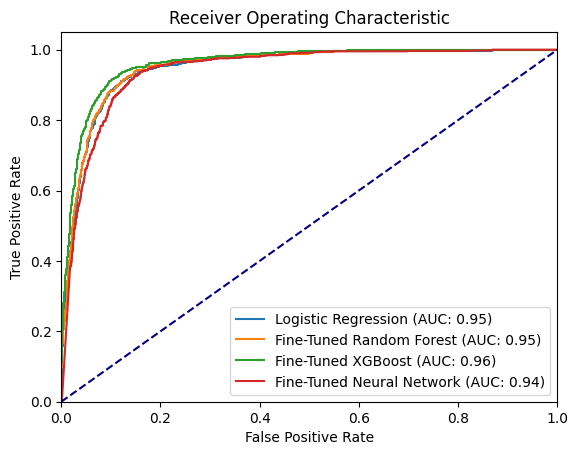

In [162]:
ynk.plot_roc_curve([lr_performance.y_pred_prob, 
                    tuned_rf_performance.y_pred_prob, 
                    tuned_xgb_performance.y_pred_prob,
                    tuned_nn_performance.y_pred_prob], 
                   ['Logistic Regression', 
                    'Fine-Tuned Random Forest',
                    'Fine-Tuned XGBoost', 
                    'Fine-Tuned Neural Network'], 
                   y_test)

## III. 5 Stacking Classifier

In this stacking classifier, we will use the best models from the previous section to build a new model. Also, we included gradient boosting (GBM) as an additional model in the stack. Params used in these model have already been tuned in the previous section

In [163]:
# stacked_pipeline = create_stacking_classifier(preprocessor=preprocessor)

In [164]:
# stacked_pipeline.fit(X_train, y_train)

In [165]:
# # export the model to a pickle file
# stacked_pkl = './models/stacked.pkl'
# with open(stacked_pkl, 'wb') as file:
#     pickle.dump(stacked_pipeline, file)

In [166]:
# import the stacked model in 
with open('./models/stacked.pkl', 'rb') as file:
    stacked_pipeline = pickle.load(file)

In [167]:
# obtain prediction 
stacked_pred, stacked_pred_prob = ynk.get_predictions(stacked_pipeline, X_test)

# obtain performance 
stacked_performance = PerformanceMetrics(y_test, stacked_pred, stacked_pred_prob)

# print out the performance
stacked_performance.print_performance_metrics('Stacking Classifier')

Performance Metrics of the model Stacking Classifier: 

Accuracy: 0.9210
Precision: 0.7836
Recall: 0.6663
ROC AUC: 0.9569
F1 Score: 0.7202


# IV. Model Evaluation

## IV. 1 Global Model Explanations

Merge all the eval metrics for all models together

In [168]:
metrics_tbl = pd.concat([create_metrics_dataframe(lr_performance, 'Logistic Regression'),
                         create_metrics_dataframe(rf_performance, 'Random Forest'),
                         create_metrics_dataframe(tuned_rf_performance, 'Tuned Random Forest'),
                         create_metrics_dataframe(xgb_performance, 'XGBoost'),
                         create_metrics_dataframe(tuned_xgb_performance, 'Tuned XGBoost'),
                         create_metrics_dataframe(nn_performance, 'Neural Network'),
                         create_metrics_dataframe(tuned_nn_performance, 'Tuned Neural Network'),
                         create_metrics_dataframe(stacked_performance, 'Stacking Classifier')])

metrics_tbl.round(4)

accuracy  precision  recall  roc_auc  f1_score
Logistic Regression     0.9134     0.7438  0.6596   0.9483    0.6992
Random Forest           0.9010     0.8042  0.4645   0.9473    0.5889
Tuned Random Forest     0.8968     0.7967  0.4346   0.9506    0.5624
XGBoost                 0.9212     0.7633  0.7007   0.9568    0.7306
Tuned XGBoost           0.9254     0.7814  0.7095   0.9603    0.7438
Neural Network          0.8929     0.6675  0.5942   0.9167    0.6287
Tuned Neural Network    0.8895     0.5951  0.8636   0.9414    0.7047
Stacking Classifier     0.9210     0.7836  0.6663   0.9569    0.7202

Since we apply standard scaling to the numerical features, we can use the coefficients from the logistic regression to interpret the importance of the features. We can also use the feature importance from the random forest and xgboost to interpret the importance of the features

### IV. 1.1 Feature Importance

`Logisi Regression`

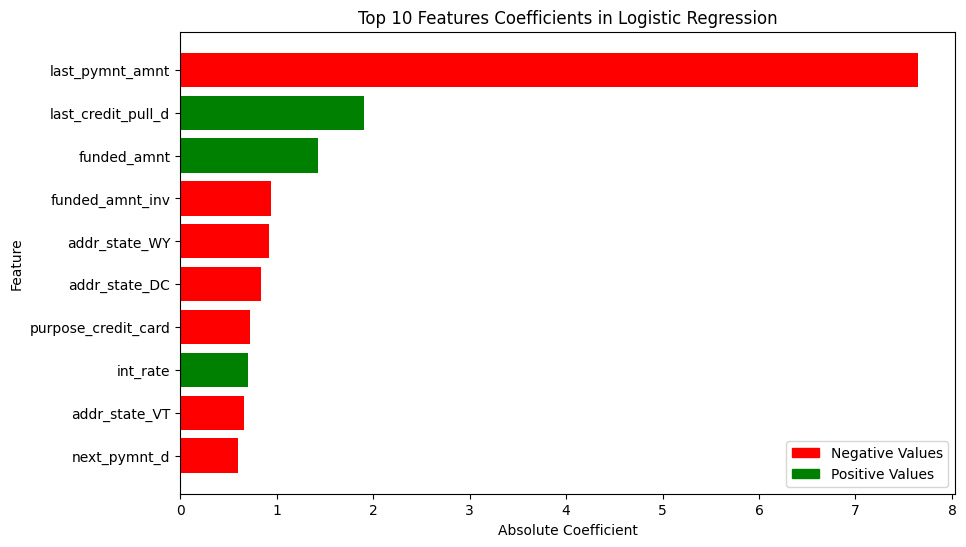

In [169]:
ynk.plot_lr_fi(lr_pipeline)

`Random Forest`

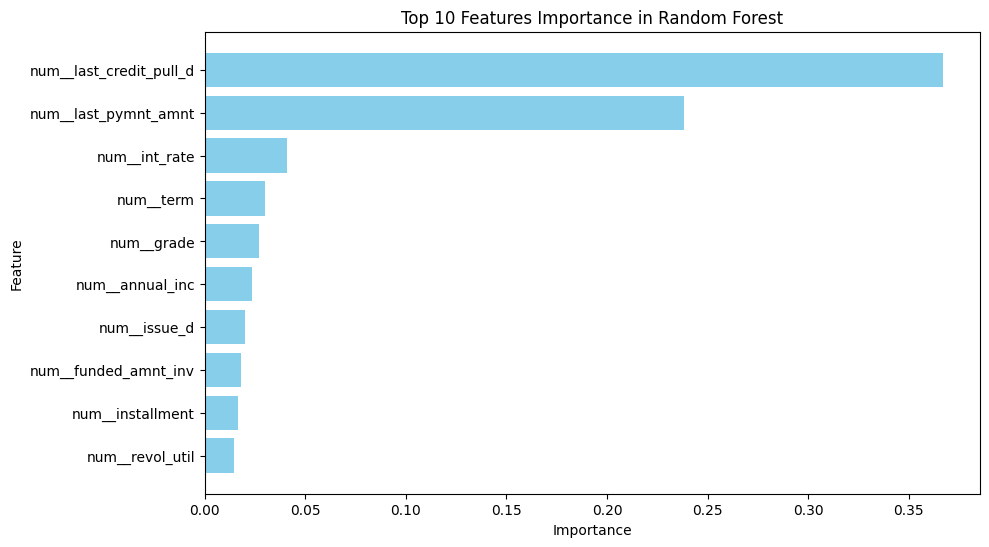

In [170]:
ynk.plot_tree_fi(tuned_rf_pipeline, title = 'Top 10 Features Importance in Random Forest')

`XGBoost`

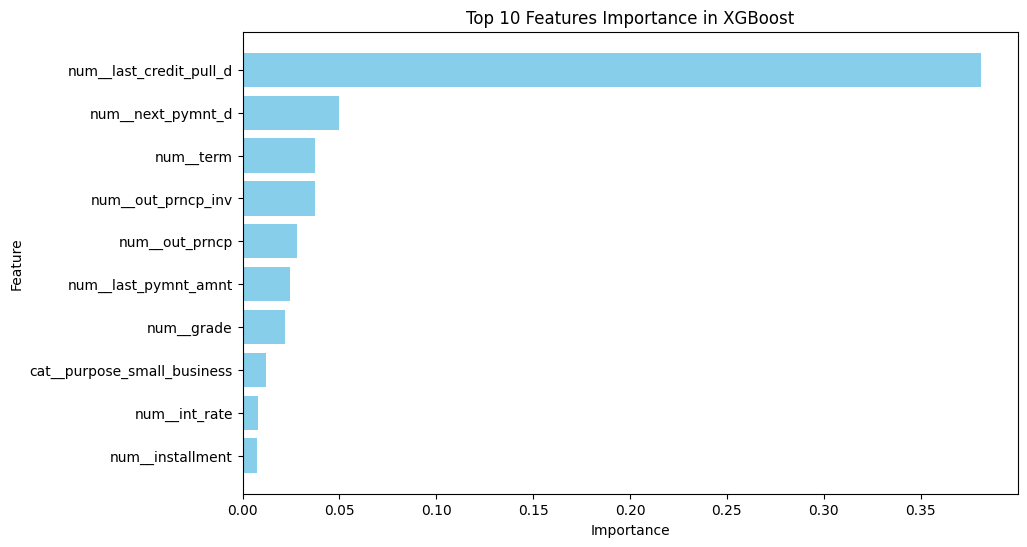

In [171]:
ynk.plot_tree_fi(tuned_xgb_pipeline, title = 'Top 10 Features Importance in XGBoost')

### IV. 1.2 ROC Curve & PR Curve

Visualize the roc curve for 5% FPR for our top models

In [172]:
top_models_pred = {'Logistic Regression': lr_performance.y_pred_prob, 
              'Tuned Random Forest': tuned_rf_performance.y_pred_prob, 
              'Tuned XGBoost': tuned_xgb_performance.y_pred_prob,
              'Tuned Neural Network': tuned_nn_performance.y_pred_prob,
              'Stacking Classifier' : stacked_performance.y_pred_prob}

ROC and PR curve for Logistic Regression


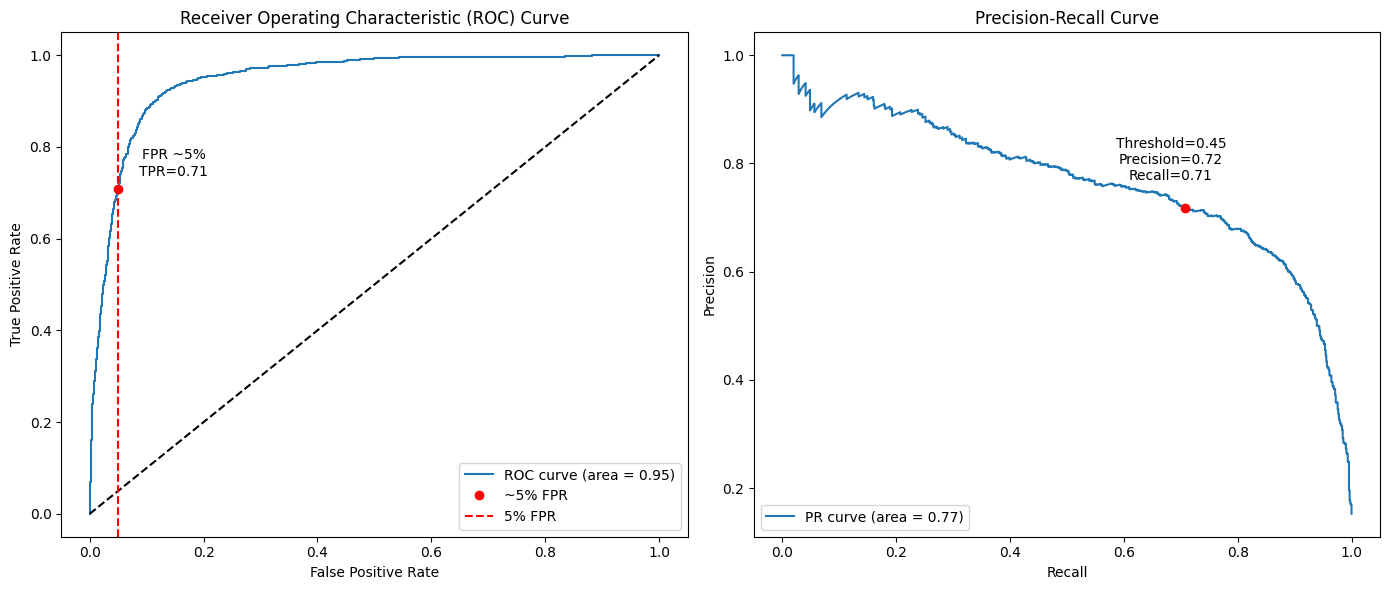



ROC and PR curve for Tuned Random Forest


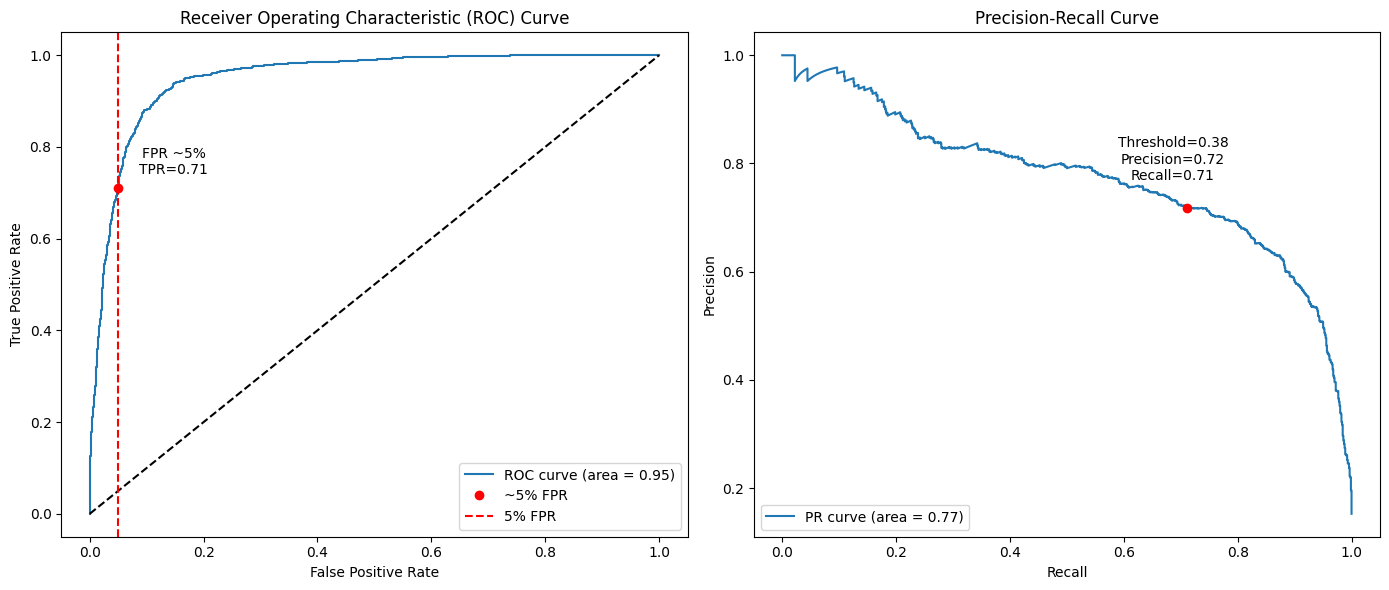



ROC and PR curve for Tuned XGBoost


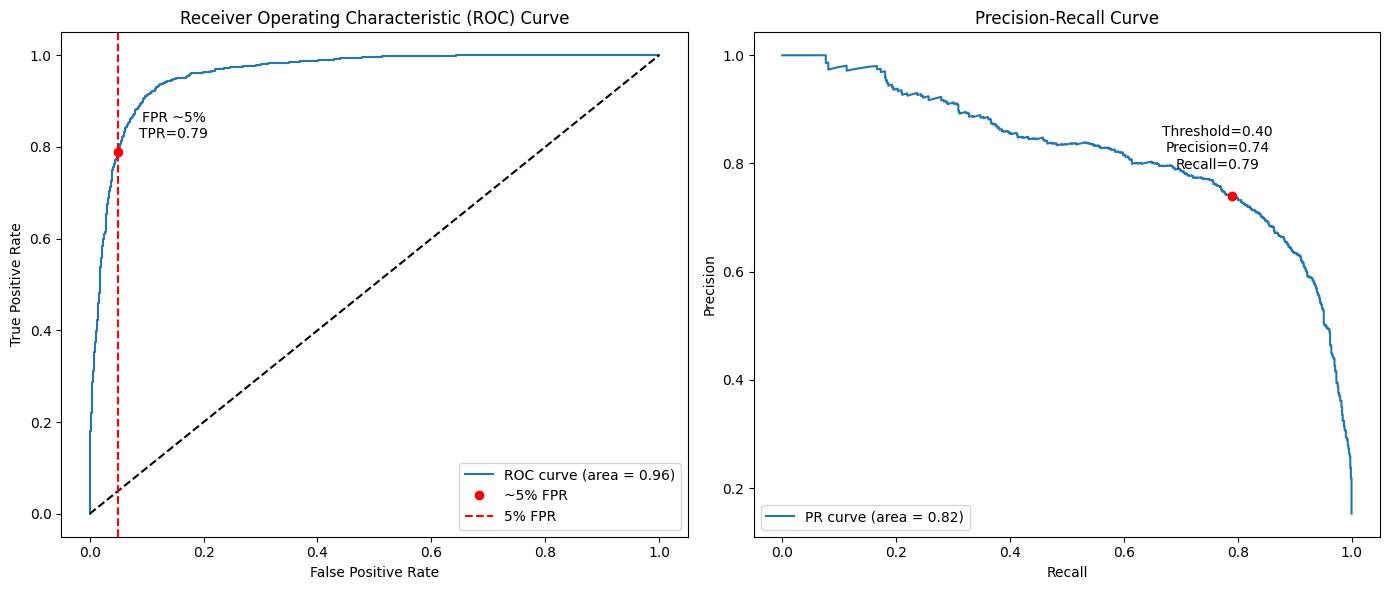



ROC and PR curve for Tuned Neural Network


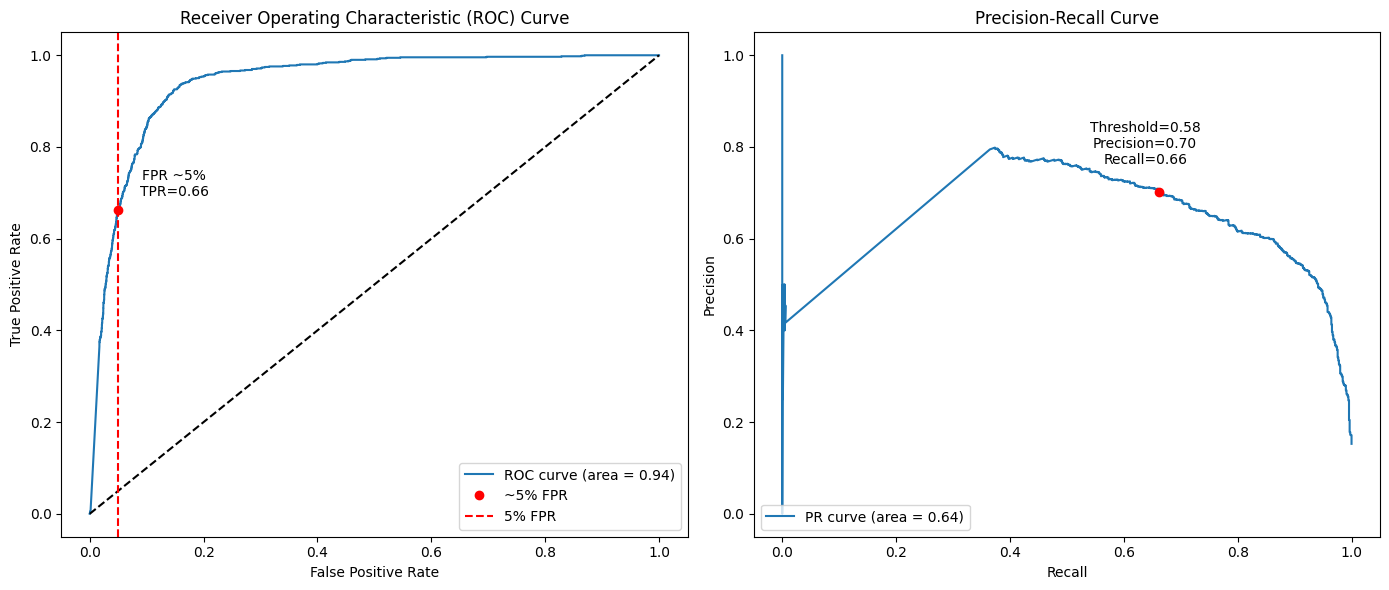



ROC and PR curve for Stacking Classifier


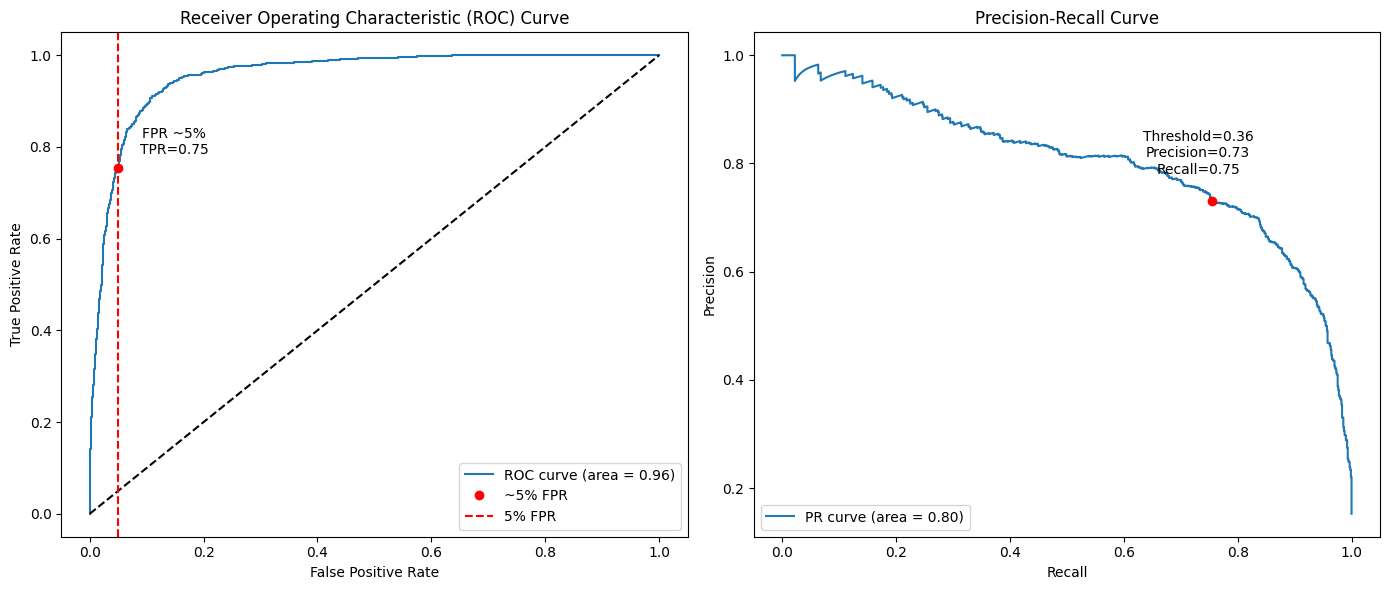

In [173]:
for model, pred in top_models_pred.items():
    print(f'ROC and PR curve for {model}')
    ynk.plot_roc_pr_curves(y_test, pred, fpr_percentile= 5)
    print('\n')

Visualize the roc curve for 2% FPR for our top models

ROC and PR curve for Logistic Regression


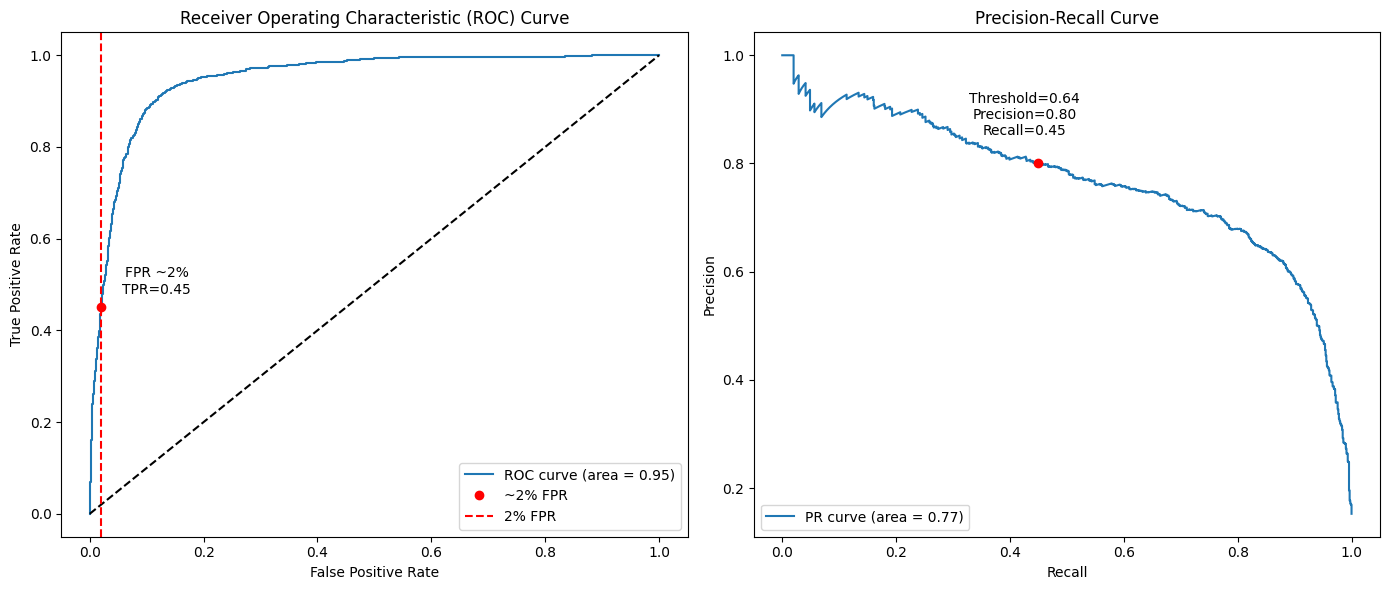



ROC and PR curve for Tuned Random Forest


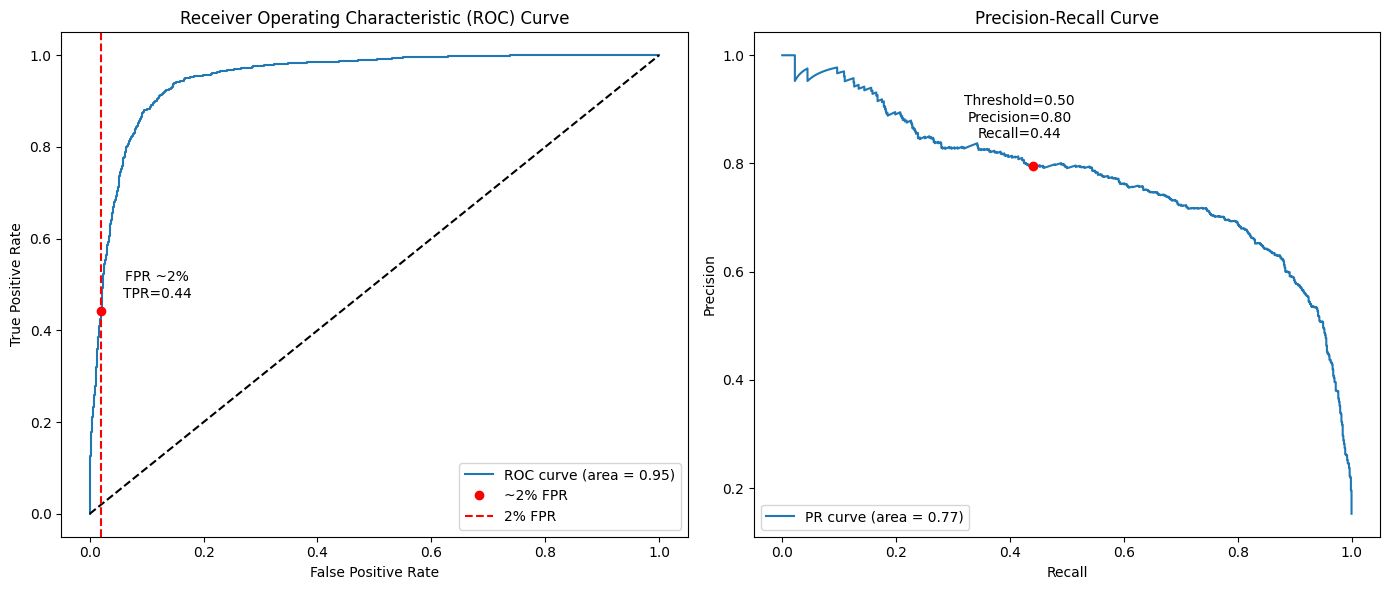



ROC and PR curve for Tuned XGBoost


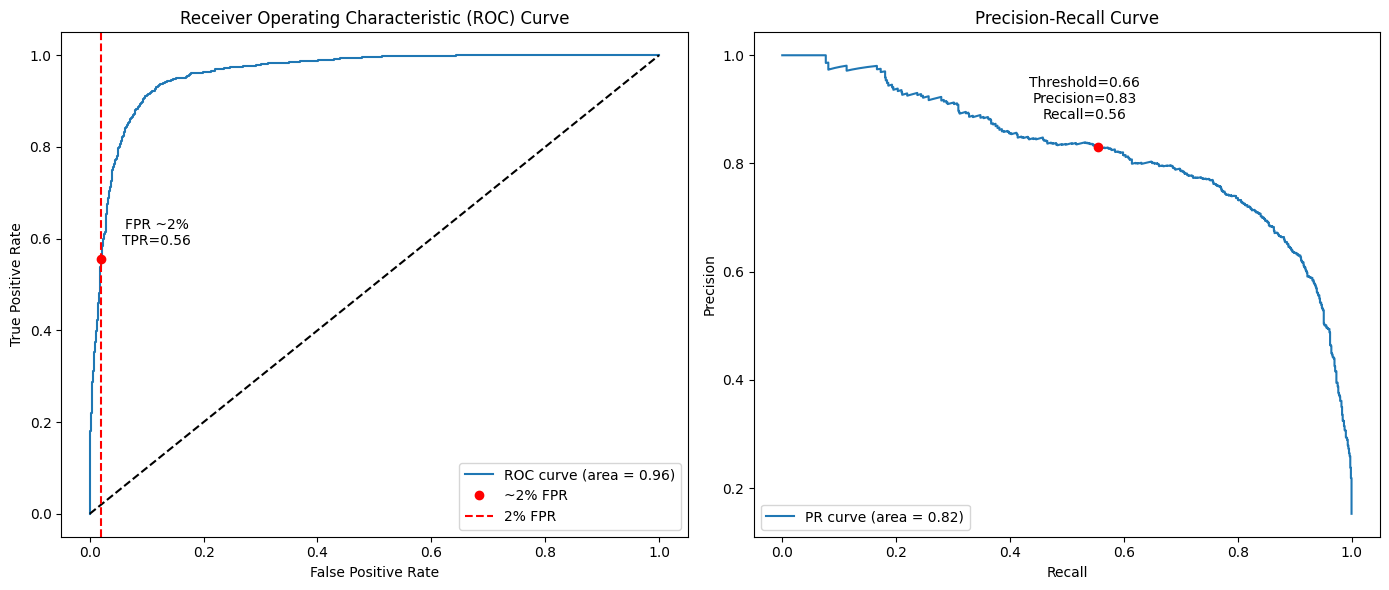



ROC and PR curve for Tuned Neural Network


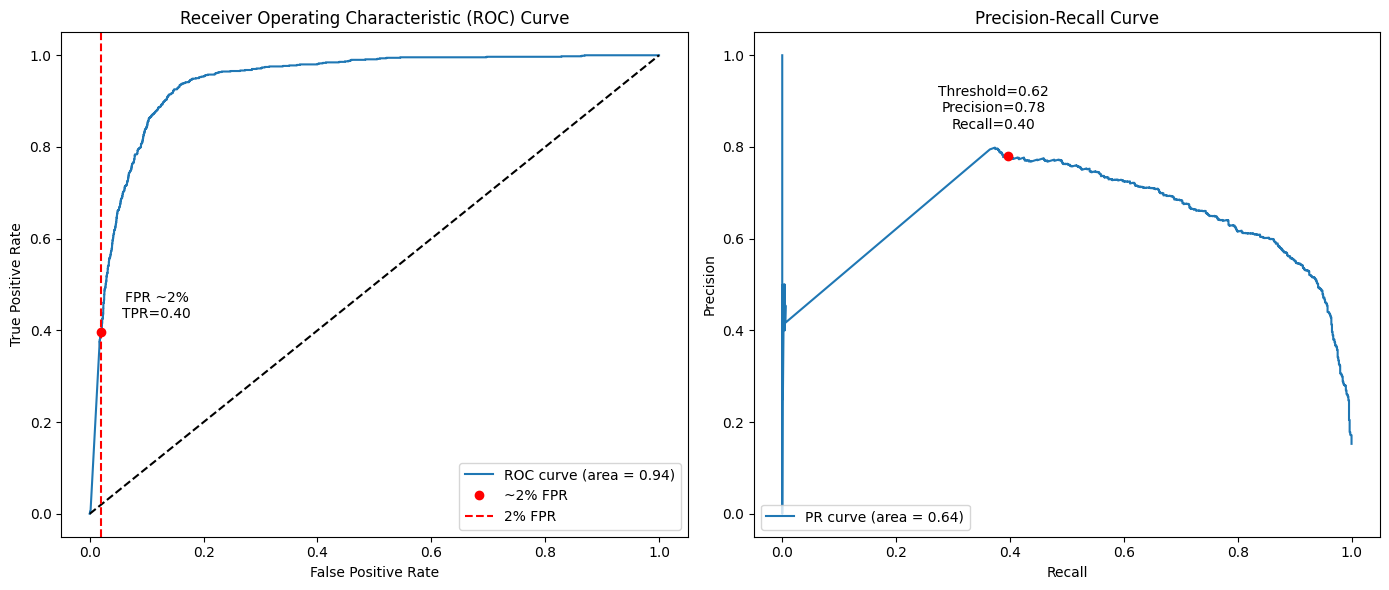



ROC and PR curve for Stacking Classifier


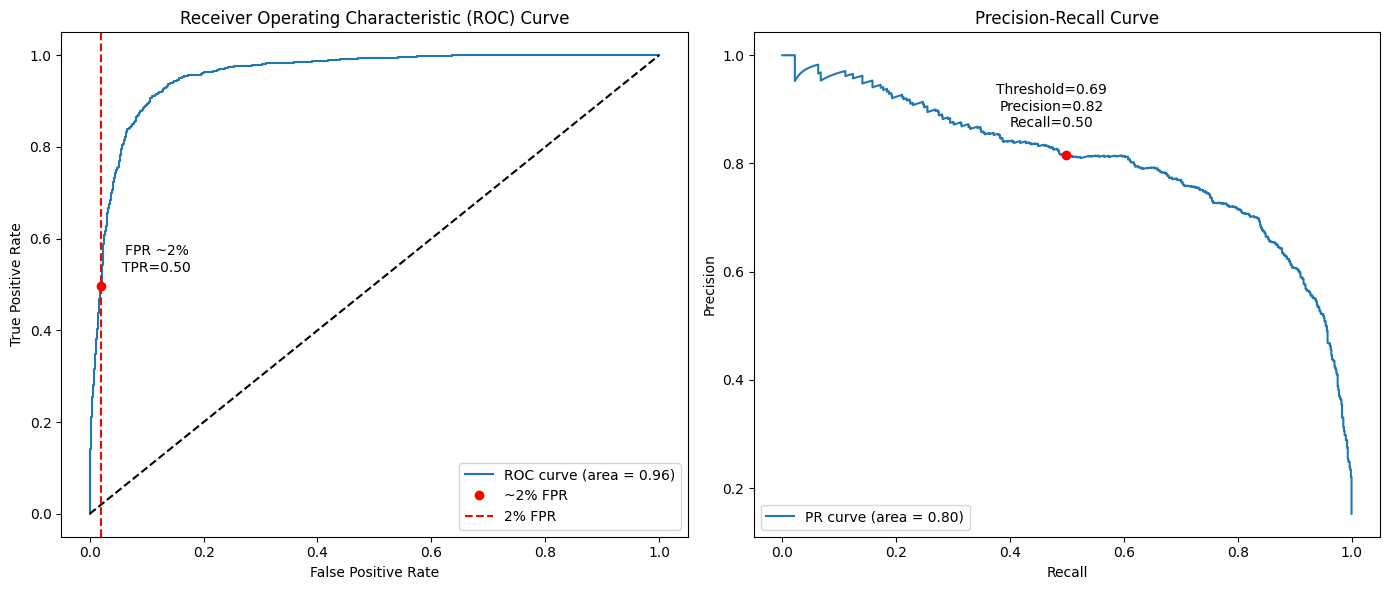

In [174]:
for model, pred in top_models_pred.items():
    print(f'ROC and PR curve for {model}')
    ynk.plot_roc_pr_curves(y_test, pred, fpr_percentile= 2)
    print('\n')

### IV. 1.3 Partial Dependence Plot

`Numerical Features`

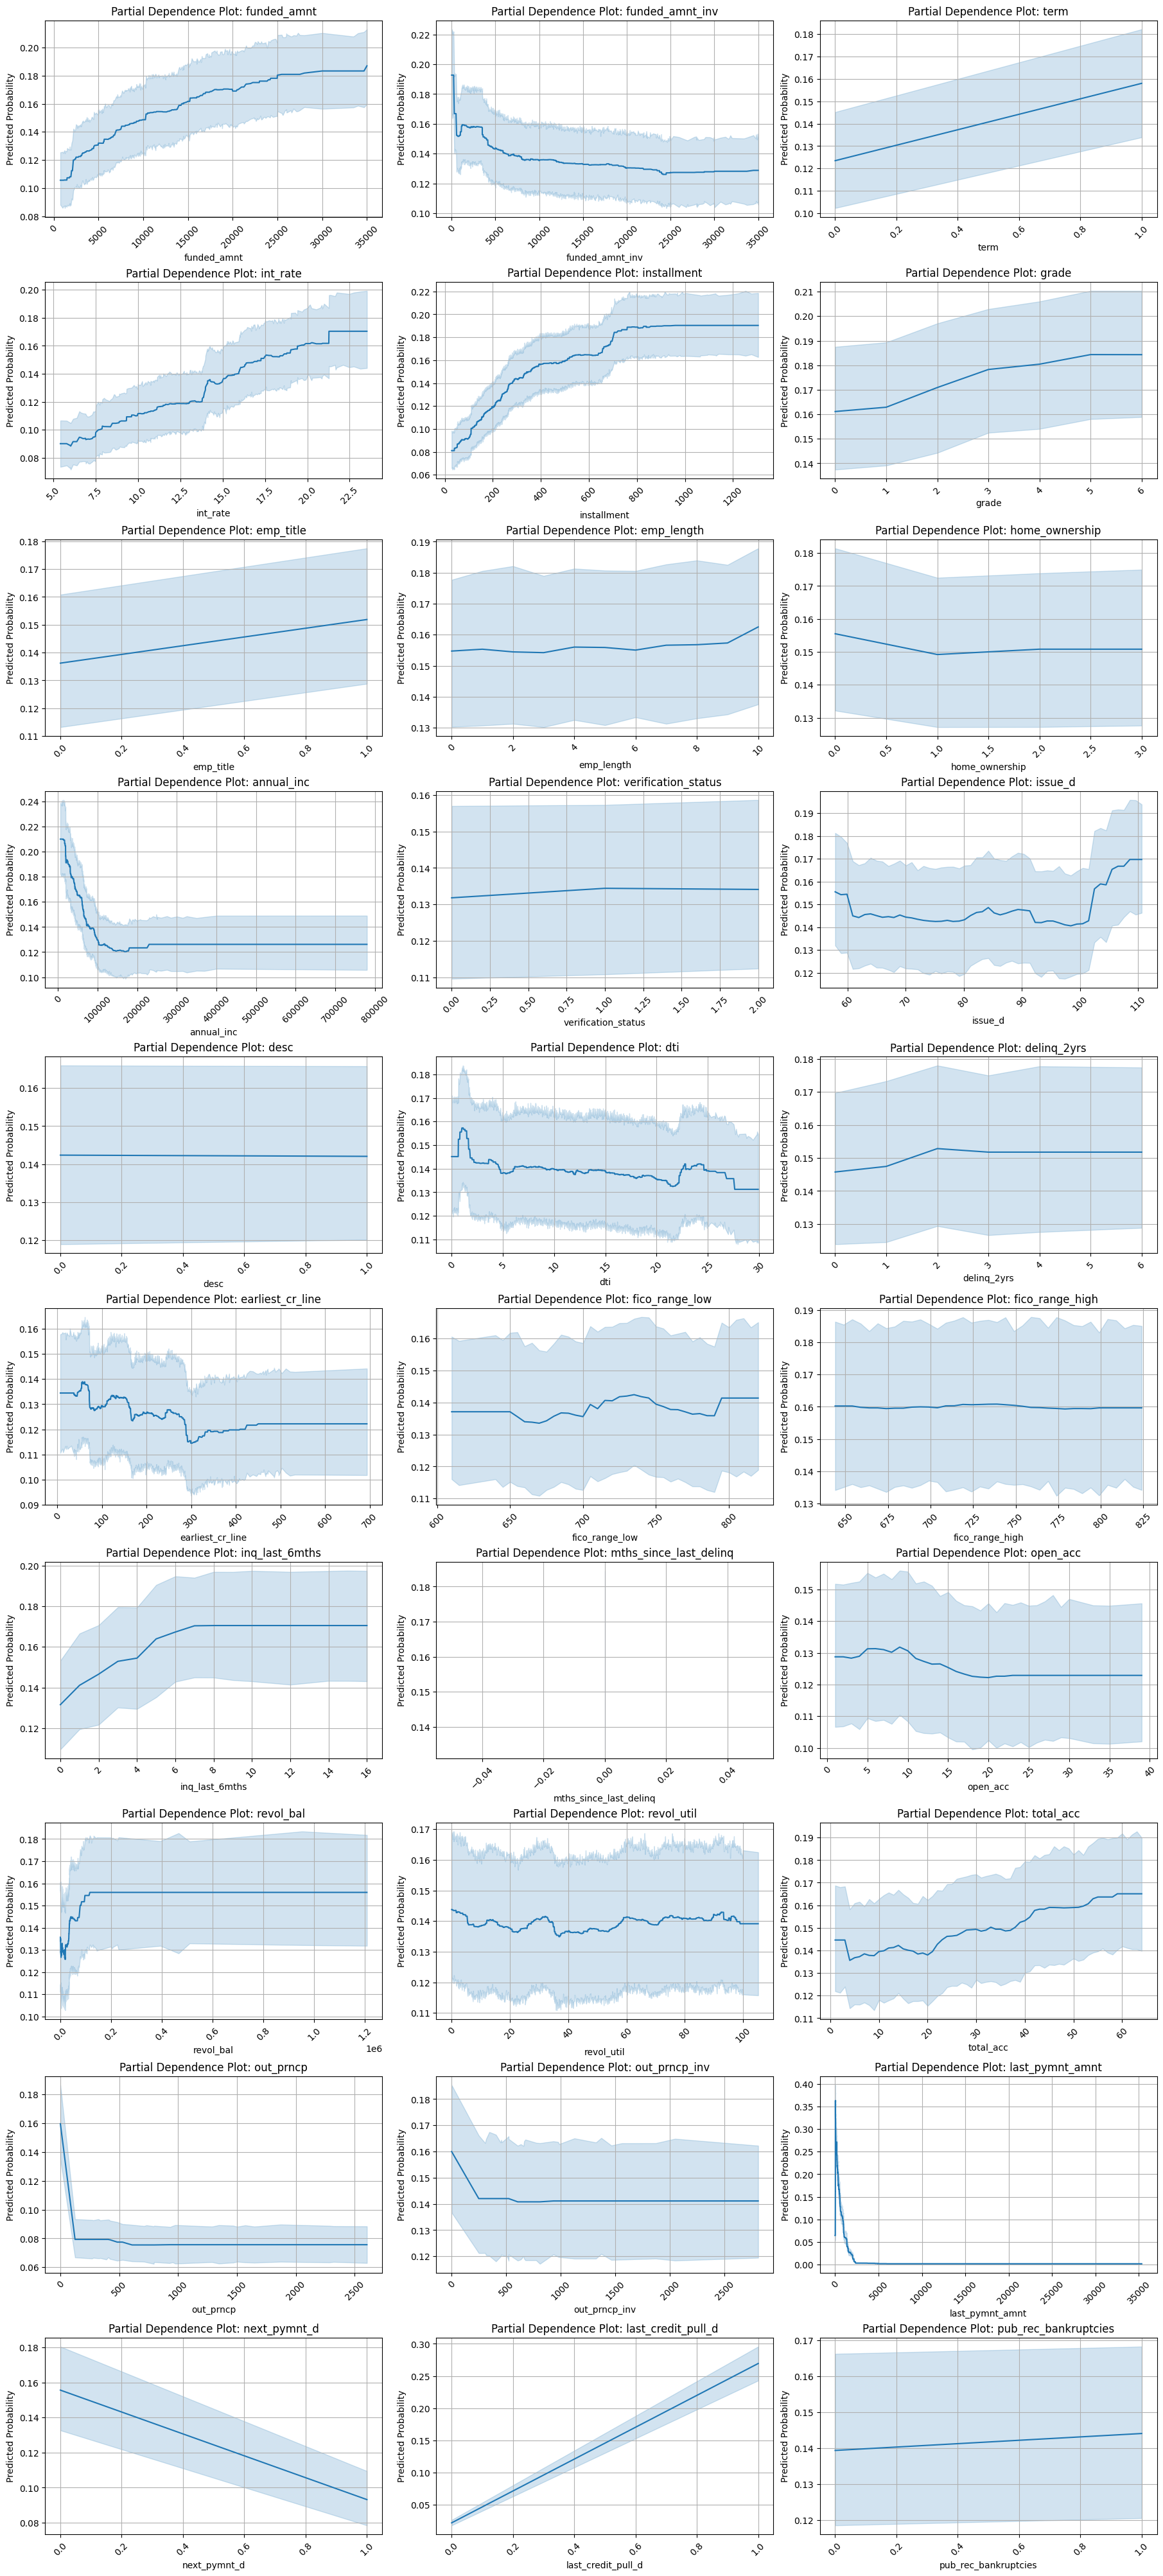

In [175]:
num_rows = (len(numerical_features) + 2) // 3 

# Create subplots with three columns, creating all subplots
fig, axes = plt.subplots(nrows=num_rows, ncols=3, figsize=(18, 4*num_rows), constrained_layout=True)

# Plot PDPs for each numerical feature
for i, num in enumerate(numerical_features):
    row = i // 3
    col = i % 3
    ynk.pdp_plot_numeric(axes[row, col], X_train, num, sample_n=500, pipeline=tuned_xgb_pipeline)

# Hide unused subplots
for i in range(len(numerical_features), num_rows * 3):
    row = i // 3
    col = i % 3
    axes[row, col].axis('off')

plt.show()

`Categorical Features`

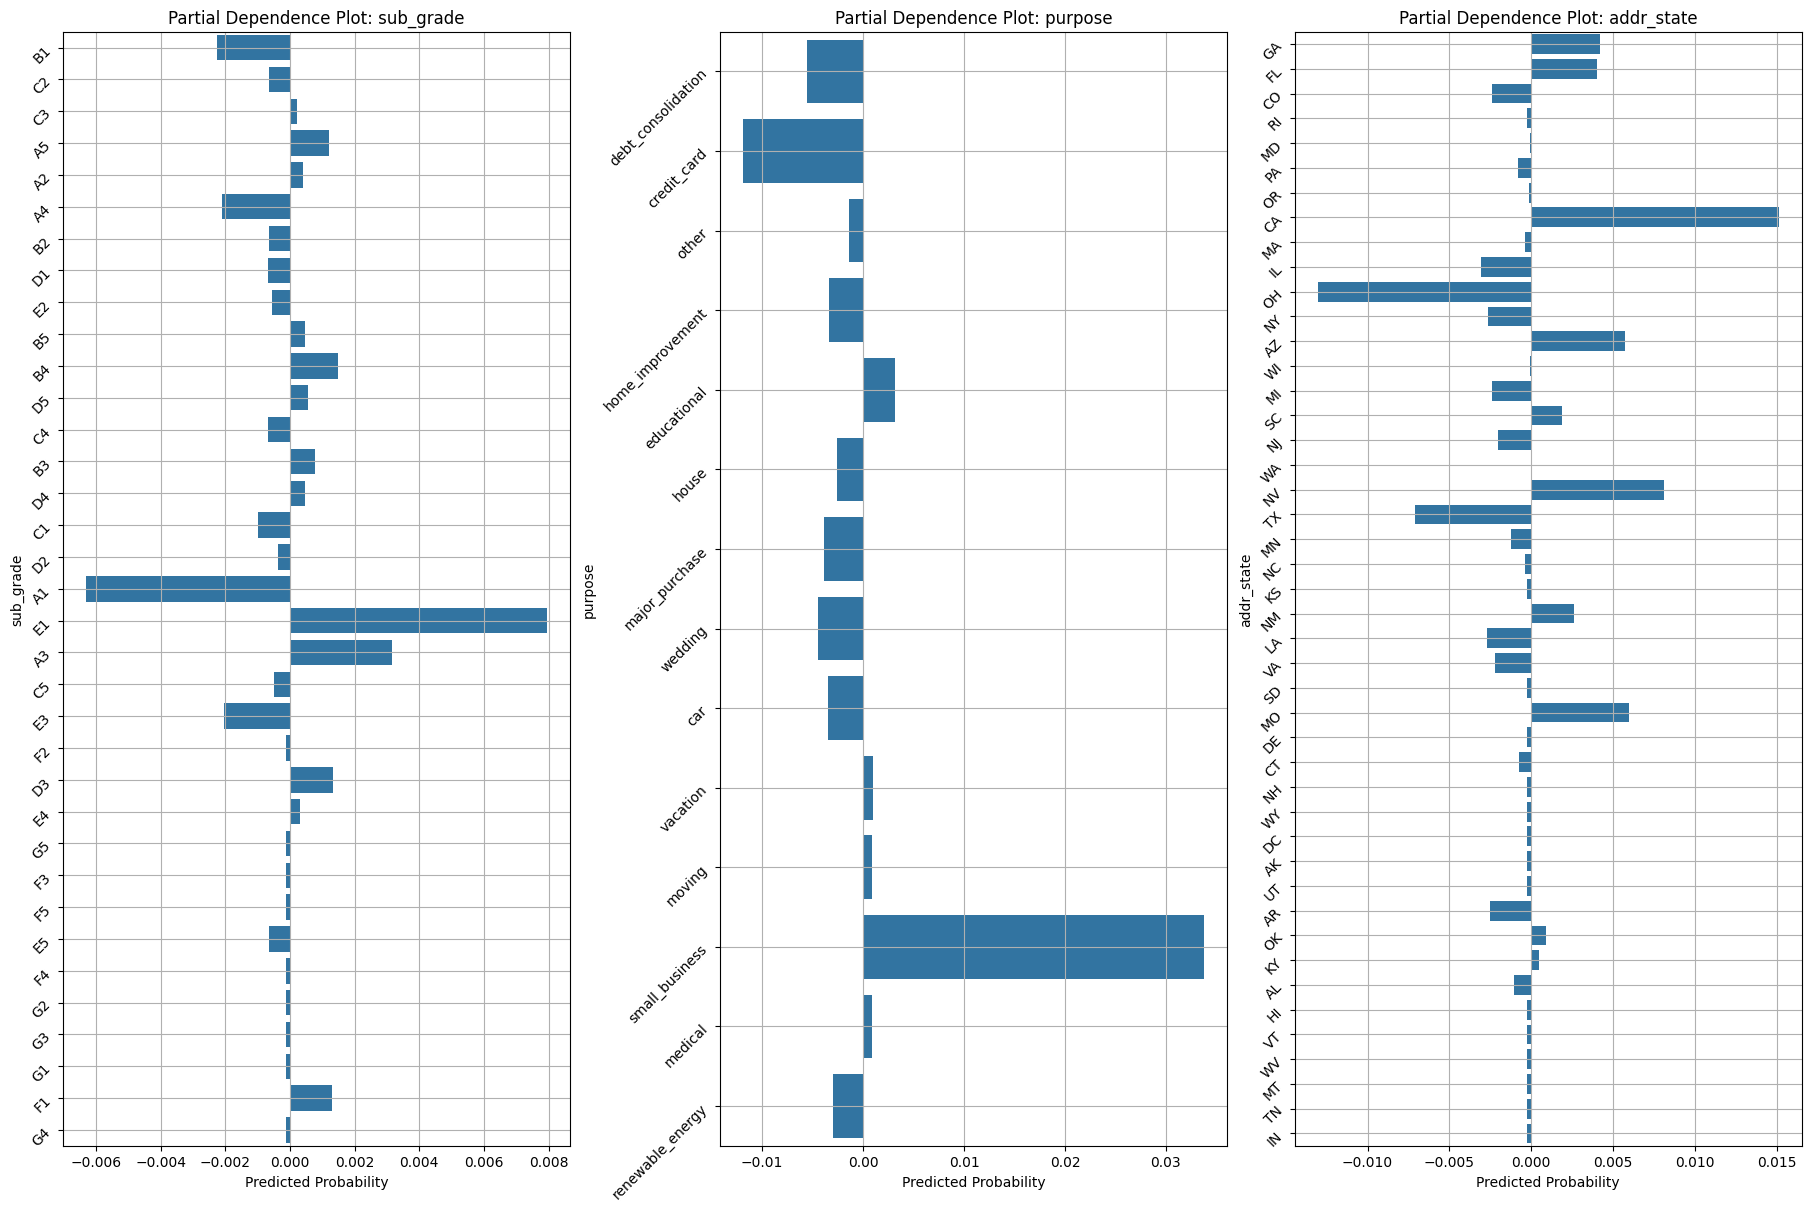

In [176]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 12), constrained_layout=True)

# Plot PDPs for each categorical feature
for i, var in enumerate(categorical_features[:3]):
    ynk.pdp_plot_categorical(axes[i], X_train, var, sample_n=500, pipeline=tuned_xgb_pipeline)

## IV. 2 Local Model Explanations

Well, of course XGBoost is the champion model, let's look into the local model explanation generated by this model

In [177]:
pipeline_explainer = dx.Explainer(tuned_xgb_pipeline, X_test, y_test)
pipeline_explainer

Preparation of a new explainer is initiated

  -> data              : 5912 rows 33 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 5912 values
  -> model_class       : xgboost.sklearn.XGBClassifier (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_proba_default at 0x000001A364BFAFC0> will be used (default)
  -> predict function  : Accepts only pandas.DataFrame, numpy.ndarray causes problems.
  -> predicted values  : min = 0.000364, mean = 0.144, max = 0.981
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.93, mean = 0.00856, max = 0.997
  -> model_info        : package sklearn

A new explainer has been created!


### IV 2.1 Top 10 best True Positive 

In [178]:
X_test['pred']= tuned_xgb_pred
X_test['pred_proba']= tuned_xgb_pred_prob
X_test['loan_status'] = y_test

In [179]:
top_10_tp = (X_test
             .query('loan_status == pred and loan_status == 1')
             .sort_values(by='pred_proba', ascending=False)
             .head(10)
             .reset_index(drop=True)
)


In [180]:
top_10_tp.head(10).T

0               1                   2  \
funded_amnt                    25000.0         24000.0             12000.0   
funded_amnt_inv             300.005174      274.997104             11975.0   
term                                 0               0                   1   
int_rate                         12.04           11.72               19.03   
installment                     830.84          793.94              311.49   
grade                                2               2                   4   
sub_grade                           C5              C4                  E2   
emp_title                            0               0                   0   
emp_length                         4.0             0.0                 2.0   
home_ownership                       1               0                   0   
annual_inc                    105000.0        140000.0             35004.0   
verification_status                  0               0                   0   
issue_d                     105.533333      105.533333           57.866667   
desc                                 0               0                   0   
purpose                 small_business  small_business  debt_consolidation   
addr_state                          WA              GA                  OH   
dti                               3.73            8.39               12.14   
delinq_2yrs                        0.0             0.0                 0.0   
earliest_cr_line             26.366667      176.566667               147.1   
fico_range_low                   700.0           705.0               725.0   
fico_range_high                  704.0           709.0               729.0   
inq_last_6mths                     2.0             8.0                 0.0   
mths_since_last_delinq               0               0                   0   
open_acc                           2.0             5.0                 4.0   
revol_bal                       1554.0         16298.0              9047.0   
revol_util                         9.1            80.7                98.3   
total_acc                          2.0            10.0                13.0   
out_prncp                          0.0             0.0                 0.0   
out_prncp_inv                      0.0             0.0                 0.0   
last_pymnt_amnt                 830.84          793.94               36.97   
next_pymnt_d                         0               0                   0   
last_credit_pull_d                   1               1                   1   
pub_rec_bankruptcies                 1               0                   0   
pred                                 1               1                   1   
pred_proba                    0.981287        0.979662            0.972376   
loan_status                          1               1                   1   

                                  3                 4                   5  \
funded_amnt                 14400.0           27575.0             15000.0   
funded_amnt_inv             14300.0           27575.0             14975.0   
term                              1                 1                   1   
int_rate                       20.3             17.58               21.67   
installment                  383.92            693.94              411.48   
grade                             4                 3                   5   
sub_grade                        E5                D4                  F3   
emp_title                         1                 0                   0   
emp_length                      NaN              10.0                 2.0   
home_ownership                    0                 0                   2   
annual_inc                  54000.0           64000.0             33000.0   
verification_status               1                 1                   2   
issue_d                        59.9         58.866667           57.866667   
desc                              1                 0                   

In [181]:
ynk.plot_local_breakdown_interactions(top_10_tp, pipeline_explainer)

### IV 2.2 Top 10 False Negative

In [182]:
top_10_fn = (X_test
             .query('loan_status != pred and loan_status == 1')
             .sort_values(by='pred_proba', ascending=True)
             .head(10)
             .reset_index(drop=True)
)
top_10_fn.head(10).T

0                   1            2  \
funded_amnt                        15925.0             16000.0      15000.0   
funded_amnt_inv                    15850.0             15900.0     14731.08   
term                                     1                   1            0   
int_rate                             20.77               15.58        10.99   
installment                         428.77              385.53       491.03   
grade                                    6                   3            1   
sub_grade                               G4                  D3           B4   
emp_title                                0                   0            0   
emp_length                             6.0                 2.0          2.0   
home_ownership                           0                   0            1   
annual_inc                        120000.0             78000.0      45000.0   
verification_status                      1                   1            0   
issue_d                          71.033333           76.133333    78.166667   
desc                                     0                   0            0   
purpose                 debt_consolidation  debt_consolidation  credit_card   
addr_state                              VA                  MN           IL   
dti                                    9.5                8.57        20.56   
delinq_2yrs                            1.0                 0.0          0.0   
earliest_cr_line                263.833333               154.2        141.0   
fico_range_low                       665.0               700.0        710.0   
fico_range_high                      669.0               704.0        714.0   
inq_last_6mths                         1.0                 1.0          0.0   
mths_since_last_delinq                   0                   0            0   
open_acc                              17.0                 9.0         10.0   
revol_bal                          29164.0              7265.0      17811.0   
revol_util                            51.8                34.3         68.8   
total_acc                             45.0                22.0         36.0   
out_prncp                              0.0                 0.0          0.0   
out_prncp_inv                          0.0                 0.0          0.0   
last_pymnt_amnt                    8480.98            10021.06       491.03   
next_pymnt_d                             0                   0            0   
last_credit_pull_d                       1                   1            0   
pub_rec_bankruptcies                     0                   0            0   
pred                                     0                   0            0   
pred_proba                        0.002519            0.003763     0.005517   
loan_status                              1                   1            1   

                                     3                   4               5  \
funded_amnt                    13000.0              4000.0         21600.0   
funded_amnt_inv                12975.0              4000.0         21575.0   
term                                 0                   0               1   
int_rate                          7.66               13.99           14.79   
installment                     405.34               136.7          511.49   
grade                                0                   2               2   
sub_grade                           A5                  C3              C4   
emp_title                            0                   0               0   
emp_length                         3.0                10.0            10.0   
home_ownership                       1                   0               0   
annual_inc                     66000.0             50400.0         32160.0   
verification_status                  1                   0               1   
issue_d                           69.0           63.966667       61.933333   
desc                     

In [183]:
ynk.plot_local_breakdown_interactions(top_10_fn, pipeline_explainer)

### IV 2.3 Top 10 False Positive

In [184]:
# top 10 false positive 
top_10_fp = (X_test
             .query('loan_status != pred and loan_status == 0')
             .sort_values(by='pred_proba', ascending=False)
             .head(10)
             .reset_index(drop=True)
)
top_10_fp.head(10).T

0               1           2  \
funded_amnt                    20000.0         29600.0      7600.0   
funded_amnt_inv                1510.13         29475.0      7575.0   
term                                 0               1           1   
int_rate                         12.61           19.69       16.77   
installment                     670.13          779.13      187.95   
grade                                3               4           3   
sub_grade                           D1              E5          D2   
emp_title                            0               0           0   
emp_length                         3.0             NaN         1.0   
home_ownership                       1               1           1   
annual_inc                     38000.0        110000.0     33996.0   
verification_status                  0               1           1   
issue_d                          104.5       61.933333   57.866667   
desc                                 0               0           0   
purpose                 small_business  small_business       other   
addr_state                          TX              CA          TX   
dti                               4.04            4.65       16.52   
delinq_2yrs                        0.0             0.0         0.0   
earliest_cr_line            118.766667           160.3  144.033333   
fico_range_low                   685.0           690.0       685.0   
fico_range_high                  689.0           694.0       689.0   
inq_last_6mths                     0.0             0.0         2.0   
mths_since_last_delinq               0               0           0   
open_acc                           3.0             9.0         6.0   
revol_bal                       4110.0         16498.0      4292.0   
revol_util                        91.3            58.7        72.7   
total_acc                         13.0            16.0        21.0   
out_prncp                          0.0             0.0         0.0   
out_prncp_inv                      0.0             0.0         0.0   
last_pymnt_amnt                 678.78          208.28       53.19   
next_pymnt_d                         0               0           0   
last_credit_pull_d                   1               1           1   
pub_rec_bankruptcies                 0               0           0   
pred                                 1               1           1   
pred_proba                    0.930232        0.928819    0.914703   
loan_status                          0               0           0   

                                     3                 4          5  \
funded_amnt                     2825.0            5000.0     2400.0   
funded_amnt_inv                 1700.0            5000.0     2400.0   
term                                 0                 1          1   
int_rate                          9.64              15.7      17.19   
installment                      90.68             120.8       59.9   
grade                                1                 3          4   
sub_grade                           B4                D4         E3   
emp_title                            0                 0          0   
emp_length                         3.0               0.0        0.0   
home_ownership                       0                 0          1   
annual_inc                     70000.0           60000.0    12000.0   
verification_status                  0                 0          0   
issue_d                          108.6         77.166667  73.066667   
desc                                 0                 0          0   
purpose                 small_business  home_improvement        car   
addr_state                          TN                WA         MI   
dti                               18.0             17.28        7.8   
delinq_2yrs                        0.0               0.0        0.0   
earliest_cr_line            122.733333             181.6  62.933333   
fico_range_low            

In [185]:
ynk.plot_local_breakdown_interactions(top_10_fp, pipeline_explainer)

# V. Prediction on Holdout Data

In [186]:
# import the holdout data
holdout = pd.read_csv('./data/loan_holdout.csv')
holdout_id = holdout['id']

In [187]:
# preprocess the holdout data
holdout = dp.feature_engineering_pipeline(holdout)

In [188]:
# predictions on the holdout data using tuned xgboost model
holdout_pred, holdout_pred_prob = ynk.get_predictions(tuned_xgb_pipeline, holdout)

In [189]:
# create a dataframe for the holdout predictions
holdout_pred_df = pd.DataFrame({
    'id': holdout_id,
    'P_DEFAULT ': holdout_pred_prob
})

# save the holdout predictions to a csv file
holdout_pred_df.to_csv('./data/holdout_predictions.csv', index=False)